In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize, LogNorm, ListedColormap

import matplotlib.colors as mcolors
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

sys.path.append('../')
sys.path.append('../pywrdrb/')

# Custom modules
from pywrdrb.post.ensemble import ensemble_mean
from pywrdrb.post.get_results import get_pywr_results, get_base_results, get_all_historic_reconstruction_pywr_results
from pywrdrb.pywr_drb_node_data import upstream_nodes_dict
from pywrdrb.utils.constants import cms_to_mgd, cm_to_mg, cfs_to_mgd, delTrenton_target, delMontague_target
from pywrdrb.utils.lists import reservoir_list, majorflow_list, reservoir_link_pairs, reservoir_list_nyc, reservoir_link_pairs
from pywrdrb.utils.directories import input_dir, fig_dir, output_dir, model_data_dir
from pywrdrb.utils.hdf5 import get_hdf5_realization_numbers, extract_realization_from_hdf5
from pywrdrb.plotting.styles import base_model_colors, model_hatch_styles, paired_model_colors, scatter_model_markers
from pywrdrb.plotting.styles import model_colors_historic_reconstruction, model_label_dict
from pywrdrb.plotting.ensemble_plots import plot_ensemble_nyc_storage
from pywrdrb.plotting.plotting_functions import subset_timeseries
from pywrdrb.pywr_drb_node_data import obs_site_matches
from pywrdrb.utils.reservoir_data import get_reservoir_capacity, load_historic_nyc_storage, load_lower_basin_elevations, load_lower_basin_storage_curves

from pywrdrb.plotting.ensemble_plots import plot_ensemble_nyc_storage, plot_NYC_release_components_combined



from pywrdrb.utils.lists import reservoir_list_nyc, drbc_lower_basin_reservoirs
from pywrdrb.plotting.plotting_functions import subset_timeseries
from pywrdrb.plotting.styles import model_label_dict, model_colors_historic_reconstruction
from pywrdrb.pywr_drb_node_data import upstream_nodes_dict, downstream_node_lags, immediate_downstream_nodes_dict


# Custom modules
from pywrdrb.utils.constants import delTrenton_target, delMontague_target
from pywrdrb.utils.lists import reservoir_list, reservoir_list_nyc, majorflow_list
from pywrdrb.utils.directories import input_dir, fig_dir, output_dir, model_data_dir
from pywrdrb.plotting.styles import base_model_colors, model_label_dict
from pywrdrb.plotting.styles import model_colors_historic_reconstruction
from pywrdrb.utils.reservoir_data import get_reservoir_capacity


fig_dir = fig_dir + '/historic_reconstruction/'


model_labels = {
    'obs': 'Observed',
    'nhmv10' : 'NHMv1.0',
    'nwmv21' : 'NWMv2.1',
    'obs_pub_nhmv10' : 'PUB-NHM',
    'obs_pub_nhmv10_ensemble' : 'PUB-NHM Ensemble',
    'obs_pub_nwmv21' : 'PUB-NWM',
    'obs_pub_nwmv21_ensemble':'PUB-NWM Ensemble',
    'obs_pub_nhmv10_ObsScaled' : 'PUB-NHM',
    'obs_pub_nhmv10_ObsScaled_ensemble' : 'PUB-NHM Ensemble',
    'obs_pub_nwmv21_ObsScaled' : 'PUB-NWM',
    'obs_pub_nwmv21_ObsScaled_ensemble':'PUB-NWM Ensemble'
    }

start_date = '1945-01-01'
end_date = '2022-12-31'

start_1960s_drought = '1964-01-01'
end_1960s_drought = '1967-01-01'

start_1980s_drought = '1980-06-01'
end_1980s_drought = '1982-10-31'

start_ffmp = pd.to_datetime('2017-10-01')
end_ffmp = pd.to_datetime('2022-12-31')

nyc_reservoir_capacities = {}
for res in reservoir_list_nyc:
    nyc_reservoir_capacities[res] = get_reservoir_capacity(res)
nyc_reservoir_capacities['NYCTotal'] = sum(nyc_reservoir_capacities.values())


In [2]:
import numpy as np
group_numbers = np.arange(1, 18)
group_numbers = np.delete(group_numbers, [1, 6])

presenters = np.random.choice(group_numbers, 4, replace=False)
presenters

array([ 1, 10,  9,  4])

In [3]:
## Load data    
start_date = '1950-01-01'
end_date = '2022-12-31'
ensemble_models = ['obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']
model_list = ['obs_pub_nhmv10_ObsScaled', 'obs_pub_nwmv21_ObsScaled',
              'obs_pub_nhmv10_ObsScaled_ensemble', 'obs_pub_nwmv21_ObsScaled_ensemble']
pywr_models = [f'pywr_{m}' for m in model_list]
base_models = ['obs', 'nhmv10', 'nwmv21'] + model_list[:2]


# Load Pywr-DRB simulation models
print('Loading Pywr-DRB simulation ensemble results...')
major_flows = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                        results_set='major_flow', 
                                                        start_date=start_date, end_date=end_date)
reservoir_downstream_gages = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                          results_set='reservoir_downstream_gage', 
                                                                          start_date=start_date, end_date=end_date)
lower_basin_mrf_contributions = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                 results_set='lower_basin_mrf_contributions',
                                                                 start_date=start_date, end_date=end_date)
ibt_diversions = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                 results_set='ibt_diversions',
                                                                 start_date=start_date, end_date=end_date)
catchment_consumptions = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                    results_set='catchment_consumption',
                                                                    start_date=start_date, end_date=end_date)

storages = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                        results_set='res_storage',
                                                        start_date=start_date, end_date=end_date)
ffmp_levels = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                           results_set='ffmp_level_boundaries',
                                                           start_date=start_date, end_date=end_date)
storage_levels = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                        results_set='res_level',
                                                        start_date=start_date, end_date=end_date)
reservoir_inflows = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                 results_set='inflow',
                                                                 start_date=start_date, end_date=end_date)
targets = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                 results_set='mrf_target',
                                                                 start_date=start_date, end_date=end_date)
print('Half way...')
nyc_releases = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                 results_set='nyc_release_components',
                                                                 start_date=start_date, end_date=end_date)

reservoir_releases = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                 results_set='res_release',
                                                                 start_date=start_date, end_date=end_date)
reservoir_inflows = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                                 results_set='inflow',
                                                                 start_date=start_date, end_date=end_date)
mrfs = get_all_historic_reconstruction_pywr_results(output_dir=output_dir, model_list=model_list,
                                                               results_set='all_mrf',
                                                               start_date=start_date, end_date=end_date)


# Get datetime index
datetime_index= reservoir_downstream_gages['pywr_obs_pub_nhmv10_ObsScaled'].index

# Load base (non-pywr) models
for model in base_models:
    print(model)

    reservoir_downstream_gages[model], datetime_index = get_base_results(input_dir, model, datetime_index, 'reservoir_downstream_gage')

    major_flows[model], datetime_index = get_base_results(input_dir, model, datetime_index, 'major_flow')

    reservoir_inflows[model], datetime_index = get_base_results(input_dir, model, datetime_index, 'inflow')
    
for model in pywr_models:
    if 'ensemble' in model:
        for real in reservoir_releases[model].keys():
            reservoir_downstream_gages[model][real]['NYCAgg'] = reservoir_downstream_gages[model][real][reservoir_list_nyc].sum(axis=1)
    else:
        reservoir_downstream_gages[model]['NYCAgg'] = reservoir_downstream_gages[model][reservoir_list_nyc].sum(axis=1)
        
for model in base_models:
    reservoir_downstream_gages[model]['NYCAgg'] = reservoir_downstream_gages[model][reservoir_list_nyc].sum(axis=1)
    

Loading Pywr-DRB simulation ensemble results...
Half way...
obs
nhmv10
nwmv21
obs_pub_nhmv10_ObsScaled
obs_pub_nwmv21_ObsScaled


In [4]:
step = 4
drought_level_mrf_days = 0
lower_basin_mrf_days = 0
drbc_max_usable_storages = {
    'beltzvilleCombined': 13500,
    'blueMarsh':  7450,
    'nockamixon': 13000
    }
priority_use_during_drought = [
    [1, 'beltzvilleCombined', 0.737],
    [1, 'blueMarsh', 0.689],
    [2, 'nockamixon', 0.687],
    [3, 'beltzvilleCombined', 0.380],
    [4, 'blueMarsh', 0.368],
    [5, 'beltzvilleCombined', 0.034],
    [5, 'blueMarsh', 0.130],
    [6, 'nockamixon', 0.010]]

lowest_lower_basin_drawdowns = {
    'beltzvilleCombined': 0.034,
    'blueMarsh': 0.13,
    'nockamixon': 0.01}

for m in ['pywr_obs_pub_nhmv10_ObsScaled_ensemble']:
    if 'ensemble' in m:
        for r in list(mrfs[m].keys()):
            print(f'Realization: {r}')
            nyc_level = storage_levels[m][r]['nyc']
            trenton_req = mrfs[m][r][f'release_needed_mrf_trenton_step{step}']
            lb_cont = lower_basin_mrf_contributions[m][r].sum(axis=1)
            
            # assert trenton req is 0 when lb_cont is 0 and nyc_level==6
            start_mrf_req = None
            for i in range(len(trenton_req)):
                
                if trenton_req[i]>0.0 and nyc_level[i]==6:
                    start_mrf_req = i if start_mrf_req is None else start_mrf_req
                    drought_level_mrf_days += 1
                    if lb_cont[i] == 0.0:
                        lb_storages = {}
                        # check if lower basin storage is below lowest priority
                        storage_is_available = False
                        current_percentages = {}
                        max_allowables = {}
                        for reservoir in drbc_lower_basin_reservoirs:
                            max_storage = drbc_max_usable_storages[reservoir]
                            if reservoir == 'nockamixon':
                                check_step = step
                                ti = i
                            else:
                                check_step = step-1
                                ti = i-1
                            current_storage = storages[m][r][reservoir][ti]
                            current_percent = current_storage/max_storage
                            current_percentages[reservoir] = current_percent
                            max_allowable = mrfs[m][r][f'max_mrf_trenton_step{check_step}_{reservoir}'][ti]
                            max_allowables[reservoir] = max_allowable
                            storage_is_available = (current_percent > lowest_lower_basin_drawdowns[reservoir]) or storage_is_available
                            
                        if storage_is_available:
                            if i == start_mrf_req:
                                print('Failure at start of MRF period')
                            else:
                                print(f'Failure {i-start_mrf_req} days after start of MRF period')
                            for reservoir in drbc_lower_basin_reservoirs:
                                priorities = [p[0] for p in priority_use_during_drought if (p[1] == reservoir) and (p[2] <= current_percentages[reservoir])]
                                priority_level = priorities[0] if len(priorities)>0 else 999
                                print(f'{reservoir} max allowed: {max_allowables[reservoir]}, priority lvl {priority_level} storage {current_percentages[reservoir]*100:.2f}%')
                        else:
                            lower_basin_mrf_days += 1  
                    
                    else:
                        lower_basin_mrf_days += 1
                        # print('Success! Lower basin is used!')
                else:
                    start_mrf_req = None
print(f'Lower basin properly used {lower_basin_mrf_days} out of {drought_level_mrf_days} days ({lower_basin_mrf_days/drought_level_mrf_days*100:.2f}%)')

Realization: realization_0
Realization: realization_1
Realization: realization_2
Realization: realization_3
Realization: realization_4
Realization: realization_5
Realization: realization_6
Realization: realization_7
Realization: realization_8
Realization: realization_9
Realization: realization_10
Realization: realization_11
Realization: realization_12
Realization: realization_13
Realization: realization_14
Realization: realization_15
Realization: realization_16
Realization: realization_17
Realization: realization_18
Realization: realization_19
Realization: realization_20
Realization: realization_21
Realization: realization_22
Realization: realization_23
Realization: realization_24
Realization: realization_25
Realization: realization_26
Realization: realization_27
Realization: realization_28
Realization: realization_29
Realization: realization_30
Realization: realization_31
Realization: realization_32
Realization: realization_33
Realization: realization_34
Realization: realization_35
Re

In [5]:


def get_subplot_handles_and_labels(axs):
    # Gather legend handles and labels from all subplots and combine into single legend
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l
    # get only unique handles and labels
    handles, labels = np.array(handles), np.array(labels)
    idx = np.unique(labels, return_index=True)[1]
    handles, labels = handles[idx], labels[idx]
    return handles, labels


def create_mirrored_cmap(cmap_name):
    original_cmap = plt.cm.get_cmap(cmap_name)
    reversed_cmap = original_cmap.reversed()
    combined_colors = np.vstack((original_cmap(np.linspace(0, 1, 128)),
                                 reversed_cmap(np.linspace(0, 1, 128))))
    mirrored_cmap = mcolors.LinearSegmentedColormap.from_list('mirrored_' + cmap_name, combined_colors)
    return mirrored_cmap



def clean_xtick_labels(axes, start_date, end_date, 
                       fontsize=10, date_format='%Y', 
                       max_ticks=10, rotate_labels=False):
    """
    Clean up x-axis tick labels for time series data.
    """
    try:
        start_date = pd.to_datetime(start_date) if isinstance(start_date, str) else start_date
        end_date = pd.to_datetime(end_date) if isinstance(end_date, str) else end_date

        if start_date >= end_date:
            raise ValueError(f"Start date must be before end date. Start: {start_date}, End: {end_date}")

        total_days = (end_date - start_date).days

        if total_days <= 30:
            date_format = '%Y-%m-%d'
            tick_spacing = 'D'
        elif total_days <= 365 * 2:
            date_format = '%Y-%m'
            tick_spacing = 'MS'
        elif total_days <= 365 *6:
            date_format = '%Y'
            tick_spacing = '1YS'
        elif total_days <= 365 * 10:
            date_format = '%Y'
            tick_spacing = '2YS'            
        elif total_days <= 365 * 20:
            # Space every 5 years
            date_format = '%Y'
            tick_spacing = '5YS'
        else:
            # Space every 10 years
            date_format = '%Y'
            tick_spacing = '10YS'

        use_ticks = pd.date_range(start_date, end_date, freq=tick_spacing)
        tick_labels = [t.strftime(date_format) for t in use_ticks]

        for i in range(len(axes)):
            ax=axes[i]
            ax.set_xticks(use_ticks)
            ax.set_xticklabels(tick_labels, 
                               rotation=45 if rotate_labels else 0, 
                               fontsize=fontsize, ha='center')
            ax.tick_params(axis='x', which='minor', length=0)
            ax.xaxis.set_minor_locator(plt.NullLocator())

            # Adjust layout to ensure labels are not cut off
            ax.figure.tight_layout()

    except Exception as e:
        print(f"Error in setting tick labels: {e}")

    return axes


def plot_ensemble_percentile_cmap(ensemble_df, model, ax, q_upper_bound, q_lower_bound, alpha=1, zorder=4):
    mirror_cmap = create_mirrored_cmap('Oranges') if 'nhm' in model else create_mirrored_cmap('Blues')
    norm = Normalize(vmin=-0.1, vmax=1.1)
    # norm = Normalize(vmin=0, vmax=1)
    percentiles = np.linspace(q_lower_bound, 0.5, 50) 
    delta_percentile = percentiles[1] - percentiles[0]
    
    # Add a line at the median value
    median = ensemble_df.median(axis=1) 
    ax.plot(ensemble_df.index, median, color=mirror_cmap(norm(0.5)), 
            ls='-', zorder=zorder-1, lw=1)
    
    for i in range(len(percentiles)-1):
        lower = ensemble_df.quantile(percentiles[i], axis=1, interpolation='linear')
        upper = ensemble_df.quantile(1-percentiles[i], axis=1, interpolation='linear')
        
        
        
        if (i != len(percentiles)-1) or (i !=0):
            if not np.isclose(lower.values, upper.values).all():            
                ax.fill_between(ensemble_df.index,
                                lower,
                                upper,
                                color= mirror_cmap(norm(percentiles[i])),
                                interpolate=False, 
                                edgecolor = mirror_cmap(norm(percentiles[i])),
                                alpha=alpha, zorder=zorder, lw=0.05)
            else:
                print(f'Skipping {percentiles[i]}')
        else:
            ax.fill_between(ensemble_df.index,
                            lower,
                            upper,
                            color= mirror_cmap(norm(percentiles[i])),
                            interpolate=False, 
                            edgecolor = mirror_cmap(norm(percentiles[i])),
                            alpha=alpha, zorder=zorder, lw=1,
                            label=model_label_dict[model])
    return ax




def plot_ensemble_nyc_storage(storages, 
                              ffmp_level_boundaries,
                              models, 
                              colordict = model_colors_historic_reconstruction,
                              start_date = '1999-10-01', end_date = '2010-05-31', 
                              fig_dir=fig_dir, 
                              plot_ensemble_mean = False,
                              percentile_cmap=False,
                              q_lower_bound = 0.05,
                              q_upper_bound = 0.95,
                              fill_ffmp_levels = True, 
                              plot_observed = True,
                              ax = None,
                              legend=True,
                              ensemble_fill_alpha = 0.8,
                              smoothing_window=1,
                              fontsize=10,
                              ffmp_fill_alpha = 0.3,
                              dpi=200):    
    """
    """
    if 'ensemble' in model:
        use_contribution_model = model + '_mean'
        colordict[use_contribution_model] = colordict[model]
        model_label_dict[use_contribution_model] = model_label_dict[model] + 'Mean'
        
        # get ensemble mean for each dataset
        storages[use_contribution_model] = ensemble_mean(storages[model])
    else:
        use_contribution_model = model
    
    if ax is None:
        fig, ax = plt.subplots(1,1,
                               figsize=(8, 3.5),
                               dpi = dpi)
        is_subplot = False
    else:
        is_subplot = True
    

    ### get reservoir storage capacities
    capacities = {r: get_reservoir_capacity(r) for r in reservoir_list_nyc}
    capacities['combined'] = sum([capacities[r] for r in reservoir_list_nyc])

    ffmp_level_boundaries = subset_timeseries(ffmp_level_boundaries, start_date, end_date) * 100
    ffmp_level_boundaries['level1a'] = 100.


    ### First plot FFMP levels as background color
    levels = [f'level{l}' for l in ['1a','1b','1c','2','3','4','5']]
    level_colors = [cm.get_cmap('Blues')(v) for v in [0.3, 0.2, 0.1]] +\
                    ['papayawhip'] +\
                    [cm.get_cmap('Reds')(v) for v in [0.1, 0.2, 0.3]]
    level_alpha = [0.5]*3 + [0.5] + [0.5]*3
    x = ffmp_level_boundaries.index
    
    if fill_ffmp_levels:    
        for i in range(len(levels)):
            y0 = ffmp_level_boundaries[levels[i]]
            if i == len(levels)-1:
                y1 = 0.
            else:
                y1 = ffmp_level_boundaries[levels[i+1]]
            ax.fill_between(x, y0, y1, color=level_colors[i], lw=0.2, edgecolor='k',
                            alpha=level_alpha[i], zorder=1, label=levels[i])
    
    # Or just do thr drought emergency level 5
    else:
        y = ffmp_level_boundaries['level5']
        drought_color = 'maroon' # cm.get_cmap('Reds')(0.3)
        drought_threshold_ls = '-'
        
        # Fill with hatch
        ax.fill_between(x, [0.0]*len(y), y,  
                        facecolor='none',
                        edgecolor=drought_color,
                        linewidth=1.0,
                        hatch='XX',
                        alpha=0.2, zorder=1,
                        label='Drought Emergency')
        
    # Observed storage
    if plot_observed:
        historic_storage = pd.read_csv(f'{input_dir}/historic_NYC/NYC_storage_daily_2000-2021.csv', sep=',', index_col=0)
        historic_storage.index = pd.to_datetime(historic_storage.index)
        historic_storage = subset_timeseries(historic_storage['Total'], start_date, end_date)
        historic_storage *= 100/capacities['combined']
        historic_storage = historic_storage.rolling(smoothing_window, center=True).mean()
        ax.plot(historic_storage, 
                color= colordict['obs'], 
                ls = '--', 
                lw = 1.,
                label=model_label_dict['obs'], 
                zorder=10)
        
    line_colors = [colordict[m] for m in models]
    
    # Loop through models
    for m,c in zip(models,line_colors):
        
        if 'ensemble' in m:
            # Get realization numbers
            realization_numbers = list(storages[m].keys())
            for i, real in enumerate(realization_numbers):
                modeled_storage = subset_timeseries(storages[m][real][reservoir_list_nyc], start_date, end_date).sum(axis=1)
                modeled_storage *= 100/capacities['combined']
                if i == 0:
                    ensemble_modeled_storage = pd.DataFrame(modeled_storage, columns=[real], 
                                                            index=modeled_storage.index)
                else:
                    ensemble_modeled_storage[real] = modeled_storage                
                
            ensemble_modeled_storage = ensemble_modeled_storage.rolling(smoothing_window, center=True).mean()
            # Plot quantiles            
            if percentile_cmap:
                ax = plot_ensemble_percentile_cmap(ensemble_modeled_storage, 
                                                   m,
                                                   ax, 
                                                   q_lower_bound=q_lower_bound, q_upper_bound=q_upper_bound, 
                                                   alpha=ensemble_fill_alpha, zorder=2)

            else:
                ax.fill_between(ensemble_modeled_storage.index,
                    ensemble_modeled_storage.quantile(q_lower_bound, axis=1),
                    ensemble_modeled_storage.quantile(q_upper_bound, axis=1),
                    color=c, alpha=ensemble_fill_alpha, 
                    zorder=2, lw=1.6,
                    label = model_label_dict[m])

    ### clean up figure
    ax.set_xlim([start_date, end_date])
    ax.set_ylabel('Combined NYC Storage (%)', fontsize=fontsize)
    ax.set_ylim([0,100])
    
    if not is_subplot:
        ax = clean_xtick_labels([ax], start_date, end_date, fontsize=fontsize)[0]
        ax.set_xlabel('Year', fontsize=fontsize)
        ax.legend(frameon=False, fontsize=fontsize, loc='upper left', 
              bbox_to_anchor=(0.0, -0.2), ncols=3)
        
        plt.savefig(f'{fig_dir}ensemble_nyc_storage_{start_date.strftime("%Y")}_{end_date.strftime("%Y")}.png',
                    dpi=dpi, 
                    bbox_inches='tight')        
    else:
        return ax


####################################################################

def plot_ensemble_NYC_release_contributions(model,
                                     nyc_release_components,
                                     reservoir_releases,
                                     reservoir_downstream_gages,
                                     colordict= model_colors_historic_reconstruction,
                                     plot_observed=True,
                                     plot_ensemble_mean = False,
                                     percentile_cmap=False,
                                     start_date=None, end_date=None, 
                                     fig_dpi=200, fig_dir=fig_dir, 
                                     fontsize=10, use_log=False,
                                     q_lower_bound = 0.05,
                                     q_upper_bound = 0.95,
                                     smoothing_window=1,
                                     ensemble_fill_alpha = 1,
                                     contribution_fill_alpha= 0.9,
                                     ax=None):
    
    if 'ensemble' in model:
        use_contribution_model = model + '_mean'
        colordict[use_contribution_model] = colordict[model]
        model_label_dict[use_contribution_model] = model_label_dict[model] + 'Mean'
        
        # get ensemble mean for each dataset
        nyc_release_components[use_contribution_model] = ensemble_mean(nyc_release_components[model])
        reservoir_releases[use_contribution_model] = ensemble_mean(reservoir_releases[model])
        reservoir_downstream_gages[use_contribution_model] = ensemble_mean(reservoir_downstream_gages[model])
    else:
        use_contribution_model = model
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(7,3), dpi=fig_dpi)
        is_subplot = False
    else:
        is_subplot = True
    release_total = subset_timeseries(reservoir_releases[use_contribution_model][reservoir_list_nyc], 
                                      start_date, end_date).sum(axis=1)

    # Handle when mrf requirements are greater than release 
    ## TODO: Fix this!

    total_flow_released = release_total.copy()
    for c in ['mrf_target_individual', 'mrf_montagueTrenton', 'flood_release', 'spill']:
        for r in reservoir_list_nyc:
            nyc_release_components[use_contribution_model][f'{c}_{r}'] = nyc_release_components[use_contribution_model][f'{c}_{r}'].clip(lower=0, 
                                                                                                                       upper=total_flow_released)
            total_flow_released -= nyc_release_components[use_contribution_model][f'{c}_{r}']
    deficit = release_total - total_flow_released
    
    
    if np.isnan(release_total).any():
        print('Warning: NaNs in release_total.')
    
    x = release_total.index
    downstream_gage_pywr = subset_timeseries(reservoir_downstream_gages[use_contribution_model]['NYCAgg'], 
                                             start_date, end_date)
    if np.isnan(downstream_gage_pywr).any():
        print('Warning: NaNs in downstream_gage_pywr.')
    downstream_uncontrolled_pywr = downstream_gage_pywr - release_total
    
    if 'ensemble' in model:
        realizations = list(reservoir_downstream_gages[model].keys())
        for i,real in enumerate(realizations):
            realization_downstream_gage_pywr = subset_timeseries(reservoir_downstream_gages[model][real][reservoir_list_nyc], 
                                              start_date, end_date).sum(axis=1)
            if i == 0:
                ensemble_downstream_gage_pywr = pd.DataFrame(realization_downstream_gage_pywr, columns=[real], index=release_total.index)
            else:
                ensemble_downstream_gage_pywr[real] = realization_downstream_gage_pywr
        ensemble_downstream_gage_pywr = ensemble_downstream_gage_pywr.rolling(smoothing_window, center=True).mean()

        # Fill between quantiles
        if percentile_cmap:
            ax = plot_ensemble_percentile_cmap(ensemble_downstream_gage_pywr, model, ax,
                                                  q_lower_bound=q_lower_bound, q_upper_bound=q_upper_bound,
                                                  alpha=ensemble_fill_alpha, zorder=2)
        else:
            ax.fill_between(ensemble_downstream_gage_pywr.index,
                        ensemble_downstream_gage_pywr.quantile(q_lower_bound, axis=1),
                        ensemble_downstream_gage_pywr.quantile(q_upper_bound, axis=1),
                        color=colordict[model], alpha=0.85, zorder=4, lw=0.0,
                        label=model_label_dict[model])
                        
    # smoothed_downstream_gage_pywr = downstream_gage_pywr.rolling(smoothing_window, center=True).mean()
    # ax.plot(smoothed_downstream_gage_pywr, color='k', lw=1.7, zorder=5)
    # ax.plot(smoothed_downstream_gage_pywr, color=colordict[use_contribution_model], lw=1.4, 
    #         label=f'{model_label_dict[use_contribution_model]} Flow', zorder=5.1)
    
    if plot_observed:
        downstream_gage_obs = subset_timeseries(reservoir_downstream_gages['obs']['NYCAgg'], 
                                                start_date, end_date)
        downstream_gage_obs = downstream_gage_obs.rolling(smoothing_window, center=True).mean()
    
        if len(downstream_gage_obs) > 0:
            ax.plot(downstream_gage_obs, color='k', ls='--', lw=1, 
                    label='Observed Flow', zorder=10)
    ax.legend(frameon=False, loc='upper center', 
              bbox_to_anchor=(0.94, -1.25), ncols=1, fontsize=fontsize)

    ax.set_xlim([x[0], x[-1]])
    ax_twin = ax.twinx()
    ax_twin.set_ylim([0,100])

    if use_log:
        ax.semilogy()
        ymax = downstream_gage_pywr.max()
        ymin = downstream_gage_pywr.min()
        if plot_observed:
            ymax = max(ymax, downstream_gage_obs.max())
            ymin = max(ymin, downstream_gage_obs.min())
        for i in range(10):
            if ymin < 10 **i:
                ymin = 10 **(i-1)
                break
        for i in range(10):
            if ymax < 10 **i:
                ymax = 10 **(i)
                break
    else:
        ax.set_ylim([0, ax.get_ylim()[1]])
        
    ### colorbrewer brown/teal palette https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=4
    colors = ['#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a']
    

    release_components_full = subset_timeseries(nyc_release_components[use_contribution_model], start_date, end_date)
    
    release_types = ['mrf_target_individual', 'mrf_montagueTrenton', 'flood_release', 'spill']
    release_components = pd.DataFrame({release_type: release_components_full[[c for c in release_components_full.columns
                                                                              if release_type in c]].sum(axis=1)
                                       for release_type in release_types})
    release_components['uncontrolled'] = downstream_uncontrolled_pywr

    
    release_components = release_components.divide(downstream_gage_pywr, axis=0) * 100
    release_components.fillna(0, inplace=True)
    
    release_components = release_components.rolling(smoothing_window, center=True, axis=0).mean()
    release_components.fillna(0, inplace=True)
    for c in release_types:
        if np.isnan(release_components[c]).any():
            print(f'Warning: NaNs in release components for {c} after divide and rolling.')
            print(f'downstream_gage_pywr: {downstream_gage_pywr}')
            
    y1 = np.zeros(len(release_components['uncontrolled'].values))
    y2 = y1 + release_components[f'uncontrolled'].values
    y3 = y2 + release_components[f'mrf_montagueTrenton'].values
    y4 = y3 + release_components[f'mrf_target_individual'].values
    y5 = y4 + release_components[f'flood_release'].values
    y6 = y5 + release_components[f'spill'].values
    for i,y in enumerate([y2, y3, y4, y5, y6]):
        if sum(np.isnan(y)) > 0:
            print(f'Warning: NaNs in release components for y{i+1}')
    print(f'Max NYC contribution perc: {y6.max()}')
    ax_twin.fill_between(x, y5, y6, label='NYC Spill', color=colors[0], alpha=contribution_fill_alpha, lw=0, zorder=1)
    ax_twin.fill_between(x, y4, y5, label='NYC FFMP Flood', color=colors[1], alpha=contribution_fill_alpha, lw=0, zorder=1)
    ax_twin.fill_between(x, y3, y4, label='NYC FFMP Individual', color=colors[2], alpha=contribution_fill_alpha, lw=0, zorder=1)
    ax_twin.fill_between(x, y2, y3, label='NYC FFMP Downstream', color=colors[3], alpha=contribution_fill_alpha, lw=0, zorder=1)
    ax_twin.fill_between(x, y1, y2, label='Uncontrolled', color=colors[4], alpha=contribution_fill_alpha, lw=0, zorder=1)

    ax.set_ylabel('NYC Release (MGD)', fontsize=fontsize)
    ax_twin.set_ylabel('Flow Contribution (%)', fontsize=fontsize)

    ax_twin.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)
    
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
    ax_twin.set_yticks(ax_twin.get_yticks(), 
                       ax_twin.get_yticklabels(), fontsize=fontsize)
    return 


def plot_ensemble_node_flow_contributions(model,
                                          node,
                                          major_flows,
                                     nyc_release_components,
                                     lower_basin_mrf_contributions,
                                     reservoir_releases,
                                     inflows, 
                                     consumptions,
                                     diversions, 
                                     colordict= model_colors_historic_reconstruction,
                                     plot_observed=True,
                                     plot_ensemble_mean = False,
                                     percentile_cmap = False,
                                     ensemble_fill_alpha = 1,
                                     contribution_fill_alpha= 0.9,
                                     start_date=None, end_date=None, 
                                     fig_dpi=200, fig_dir=fig_dir, 
                                     fontsize=10, use_log=False,
                                     q_lower_bound = 0.05,
                                     q_upper_bound = 0.95,
                                     smoothing_window=1,
                                     ax=None):
    if 'ensemble' in model:
        use_contribution_model = model + '_mean'
        colordict[use_contribution_model] = colordict[model]
        model_label_dict[use_contribution_model] = model_label_dict[model] + 'Mean'
        
        # get ensemble mean for each dataset
        major_flows[use_contribution_model] = ensemble_mean(major_flows[model])
        nyc_release_components[use_contribution_model] = ensemble_mean(nyc_release_components[model])
        lower_basin_mrf_contributions[use_contribution_model] = ensemble_mean(lower_basin_mrf_contributions[model])
        reservoir_releases[use_contribution_model] = ensemble_mean(reservoir_releases[model])
        inflows[use_contribution_model] = ensemble_mean(inflows[model])
        consumptions[use_contribution_model] = ensemble_mean(consumptions[model])
        diversions[use_contribution_model] = ensemble_mean(diversions[model])
    else:
        use_contribution_model = model
        
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(7,3), dpi=fig_dpi)
        is_subplot = False
    else:
        is_subplot = True
        
    # Get total sim and obs flow    
    if 'ensemble' in model:
        realizations = list(major_flows[model].keys())
        for real in realizations:
            total_sim_node_flow = subset_timeseries(major_flows[model][real][node], start_date, end_date)

            ### for Trenton, add NJ diversion to simulated flow. also add Blue Marsh MRF contribution for FFMP Trenton equivalent flow
            if node == 'delTrenton':
                nj_diversion = subset_timeseries(diversions[model][real]['delivery_nj'], start_date, end_date)
                total_sim_node_flow += nj_diversion

                ### get drbc contributions from lower basin reservoirs
                realization_lower_basin_mrf_contributions = subset_timeseries(lower_basin_mrf_contributions[model][real], 
                                                                  start_date, end_date)
                realization_lower_basin_mrf_contributions.columns = [c.split('_')[-1] for c in realization_lower_basin_mrf_contributions.columns]

                # acct for lag at blue marsh so it can be added to trenton equiv flow. other flows lagged below
                if node == 'delTrenton':
                    for c in ['blueMarsh']:
                        lag = downstream_node_lags[c]
                        downstream_node = immediate_downstream_nodes_dict[c]
                        while downstream_node != 'output_del':
                            lag += downstream_node_lags[downstream_node]
                            downstream_node = immediate_downstream_nodes_dict[downstream_node]
                        if lag > 0:
                            realization_lower_basin_mrf_contributions[c].iloc[lag:] = realization_lower_basin_mrf_contributions[c].iloc[:-lag]
                total_sim_node_flow += realization_lower_basin_mrf_contributions['blueMarsh']

            if real == realizations[0]:
                ensemble_sim_node_flow = pd.DataFrame(total_sim_node_flow, columns=[real], index=total_sim_node_flow.index)
            else:
                ensemble_sim_node_flow[real] = total_sim_node_flow
        ensemble_sim_node_flow = ensemble_sim_node_flow.rolling(smoothing_window, center=True).mean()
        
        if percentile_cmap:
            ax = plot_ensemble_percentile_cmap(ensemble_sim_node_flow, model, ax, 
                                                q_lower_bound=q_lower_bound, q_upper_bound=q_upper_bound,
                                                alpha=ensemble_fill_alpha, zorder=2)
        else:
            ax.fill_between(ensemble_sim_node_flow.index,
                            ensemble_sim_node_flow.quantile(q_lower_bound, axis=1),
                            ensemble_sim_node_flow.quantile(q_upper_bound, axis=1),
                            color=colordict[model], alpha=ensemble_fill_alpha, 
                            zorder=2, lw=1.6,
                            label = model_label_dict[model])
                
    # repeat for QPPQ aggregate version
    total_sim_node_flow = subset_timeseries(major_flows[use_contribution_model][node], start_date, end_date)
        
    ### for Trenton, add NJ diversion to simulated flow. also add Blue Marsh MRF contribution for FFMP Trenton equivalent flow
    if node == 'delTrenton':
        nj_diversion = subset_timeseries(diversions[use_contribution_model]['delivery_nj'], start_date, end_date)
        total_sim_node_flow += nj_diversion

        ### get drbc contributions from lower basin reservoirs
        lower_basin_mrf_contributions = subset_timeseries(lower_basin_mrf_contributions[use_contribution_model], start_date, end_date)
        lower_basin_mrf_contributions.columns = [c.split('_')[-1] for c in lower_basin_mrf_contributions.columns]

        # acct for lag at blue marsh so it can be added to trenton equiv flow. other flows lagged below
        for c in ['blueMarsh']:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != 'output_del':
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                lower_basin_mrf_contributions[c].iloc[lag:] = lower_basin_mrf_contributions[c].iloc[:-lag]
        total_sim_node_flow += lower_basin_mrf_contributions['blueMarsh']

    nyc_release_components= nyc_release_components.copy()
    
    for r in reservoir_list_nyc:
        total_release = reservoir_releases[use_contribution_model][r].copy()
        for c in ['mrf_target_individual', 'mrf_montagueTrenton', 'flood_release', 'spill']:
            mrf_shortfall = total_release - nyc_release_components[use_contribution_model][f'{c}_{r}'] 
            mrf_shortfall[mrf_shortfall >= 0] = 0
            total_release -= nyc_release_components[use_contribution_model][f'{c}_{r}']
            total_release[total_release < 0] = 0
            
            nyc_release_components[use_contribution_model][f'{c}_{r}'] = nyc_release_components[use_contribution_model][f'{c}_{r}'] + mrf_shortfall
            
    # smoothed_total_sim_node_flow = total_sim_node_flow.rolling(smoothing_window, center=True).mean()
    # ax.plot(smoothed_total_sim_node_flow, color='k', lw=1.7)
    # ax.plot(smoothed_total_sim_node_flow, color=colordict[use_contribution_model], lw=1.4)
    
    # Plot observed flow
    if plot_observed:      
        total_obs_node_flow = subset_timeseries(major_flows['obs'][node], start_date, end_date)                
        if node == 'delTrenton':
            nj_diversion = subset_timeseries(diversions[use_contribution_model]['delivery_nj'], 
                                                    start_date, end_date)
            total_obs_node_flow += nj_diversion
        total_obs_node_flow = total_obs_node_flow.rolling(smoothing_window, center=True).mean()
  
        if len(total_obs_node_flow)>0:
            ax.plot(total_obs_node_flow, color='k', 
                    ls='--', lw=1, zorder = 10)
            
    ax_twin = ax.twinx()
    ax_twin.set_ylim([0,100])
    ax.set_xlim(start_date, end_date)
    if use_log:
        ax.semilogy()
        ymax = total_sim_node_flow.max()
        ymin = total_sim_node_flow.min()
        if plot_observed:
            ymax = max(ymax, total_obs_node_flow.max())
            ymin = max(ymin, total_obs_node_flow.min())
        for i in range(10):
            if ymin < 10 ** i:
                ymin = 10 ** (i - 1)
                break
        for i in range(10):
            if ymax < 10 ** i:
                ymax = 10 ** (i)
                break
    else:
        ax.set_ylim([0, ax.get_ylim()[1]])

    ax.set_ylabel(f'Total Flow (MGD)', fontsize=fontsize)
    ax_twin.set_ylabel('Flow Contribution (%)', fontsize=fontsize)

    # Get contributing flows
    contributing = upstream_nodes_dict[node]
    non_nyc_reservoirs = [i for i in contributing if (i in reservoir_list) and (i not in reservoir_list_nyc)]
    non_nyc_release_contributions = reservoir_releases[use_contribution_model][non_nyc_reservoirs]

    if node == 'delTrenton':
        ### subtract lower basin ffmp releases from their non-ffmp releases
        for r in drbc_lower_basin_reservoirs:
            if r != 'blueMarsh':
                non_nyc_release_contributions[r] = np.maximum(non_nyc_release_contributions[r] -
                                                                lower_basin_mrf_contributions[r], 0)

    use_inflows = [i for i in contributing if (i in majorflow_list)]
    if node == 'delMontague':
        use_inflows.append('delMontague')
    inflow_contributions = inflows[use_contribution_model][use_inflows] - consumptions[use_contribution_model][use_inflows]
    mrf_target_individuals = nyc_release_components[use_contribution_model][[c for c in nyc_release_components[use_contribution_model].columns
                                                                 if 'mrf_target_individual' in c]]
    mrf_target_individuals.columns = [c.rsplit('_',1)[1] for c in mrf_target_individuals.columns]
    mrf_montagueTrentons = nyc_release_components[use_contribution_model][[c for c in nyc_release_components[use_contribution_model].columns
                                                               if 'mrf_montagueTrenton' in c]]
    mrf_montagueTrentons.columns = [c.rsplit('_',1)[1] for c in mrf_montagueTrentons.columns]
    flood_releases = nyc_release_components[use_contribution_model][[c for c in nyc_release_components[use_contribution_model].columns if
                                                         'flood_release' in c]]
    flood_releases.columns = [c.rsplit('_',1)[1] for c in flood_releases.columns]
    spills = nyc_release_components[use_contribution_model][[c for c in nyc_release_components[use_contribution_model].columns if 'spill' in c]]
    spills.columns = [c.rsplit('_',1)[1] for c in spills.columns]

    # Impose lag
    for c in upstream_nodes_dict[node][::-1]:
        if c in inflow_contributions.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                inflow_contributions[c].iloc[lag:] = inflow_contributions[c].iloc[:-lag]
        elif c in non_nyc_release_contributions.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                non_nyc_release_contributions[c].iloc[lag:] = non_nyc_release_contributions[c].iloc[:-lag]
                if node == 'delTrenton' and c in drbc_lower_basin_reservoirs:
                    lower_basin_mrf_contributions[c].iloc[lag:] = lower_basin_mrf_contributions[c].iloc[:-lag]
                ### note: blue marsh lower_basin_mrf_contribution lagged above. 
                # It wont show up in upstream_nodes_dict here, so not double lagging.
        elif c in mrf_target_individuals.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                mrf_target_individuals[c].iloc[lag:] = mrf_target_individuals[c].iloc[:-lag]
                mrf_montagueTrentons[c].iloc[lag:] = mrf_montagueTrentons[c].iloc[:-lag]
                flood_releases[c].iloc[lag:] = flood_releases[c].iloc[:-lag]
                spills[c].iloc[lag:] = spills[c].iloc[:-lag]

    print(f'Inflows from: {inflow_contributions.columns}')
    print(f'Non-NYC releases from: {non_nyc_release_contributions.columns}')
    if node == 'delTrenton':
        print(f'Lower basin MRF contributions from: {lower_basin_mrf_contributions.columns}')
    print(f'NYC FFMP target individuals from: {mrf_target_individuals.columns}')
    print(f'NYC FFMP montagueTrentons from: {mrf_montagueTrentons.columns}')
    print(f'NYC FFMP flood releases from: {flood_releases.columns}')
    print(f'NYC spills from: {spills.columns}')
    
    inflow_contributions = subset_timeseries(inflow_contributions, start_date, end_date).sum(axis=1)
    non_nyc_release_contributions = subset_timeseries(non_nyc_release_contributions, start_date, end_date).sum(axis=1)
    if node == 'delTrenton':
        lower_basin_mrf_contributions = lower_basin_mrf_contributions.sum(axis=1)
    mrf_target_individuals = subset_timeseries(mrf_target_individuals, start_date, end_date).sum(axis=1)
    mrf_montagueTrentons = subset_timeseries(mrf_montagueTrentons, start_date, end_date).sum(axis=1)
    flood_releases = subset_timeseries(flood_releases, start_date, end_date).sum(axis=1)
    spills = subset_timeseries(spills, start_date, end_date).sum(axis=1)

    inflow_contributions = inflow_contributions.divide(total_sim_node_flow) * 100
    non_nyc_release_contributions = non_nyc_release_contributions.divide(total_sim_node_flow) * 100
    if node == 'delTrenton':
        lower_basin_mrf_contributions = lower_basin_mrf_contributions.divide(total_sim_node_flow) * 100
    mrf_target_individuals = mrf_target_individuals.divide(total_sim_node_flow) * 100
    mrf_montagueTrentons = mrf_montagueTrentons.divide(total_sim_node_flow) * 100
    flood_releases = flood_releases.divide(total_sim_node_flow) * 100
    spills = spills.divide(total_sim_node_flow) * 100

    # Apply rolling smooth across dfs
    inflow_contributions = inflow_contributions.rolling(smoothing_window, center=True).mean()
    non_nyc_release_contributions = non_nyc_release_contributions.rolling(smoothing_window, center=True).mean()
    if node == 'delTrenton':
        lower_basin_mrf_contributions = lower_basin_mrf_contributions.rolling(smoothing_window, center=True).mean()
    mrf_target_individuals = mrf_target_individuals.rolling(smoothing_window, center=True).mean()
    mrf_montagueTrentons = mrf_montagueTrentons.rolling(smoothing_window, center=True).mean()
    flood_releases = flood_releases.rolling(smoothing_window, center=True).mean()
    spills = spills.rolling(smoothing_window, center=True).mean()
    

    colors = ['#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a']

    x = total_sim_node_flow.index
    y1 = 0
    y2 = y1 + inflow_contributions
    y3 = y2 + non_nyc_release_contributions
    if node == 'delTrenton':
        y4 = y3 + lower_basin_mrf_contributions
        y5 = y4 + mrf_montagueTrentons
    else:
        y5 = y3 + mrf_montagueTrentons
    y6 = y5 + mrf_target_individuals
    y7 = y6 + flood_releases
    y8 = y7 + spills
    print(f'Max flow contribution perc: {y8.max()} at index {y8.idxmax()}')
    error_idx = y8.idxmax()
    print(f'Error at {error_idx}: {inflow_contributions.loc[error_idx]}, {non_nyc_release_contributions.loc[error_idx]}, {mrf_target_individuals.loc[error_idx]}, {mrf_montagueTrentons.loc[error_idx]}, {flood_releases.loc[error_idx]}, {spills.loc[error_idx]}')
    # assert(np.isclose(y8.values, 100).all()), f'Flow contributions do not sum to 100%. Max: {y8.max()}'
    
    ax_twin.fill_between(x, y7, y8, label='NYC Spill', color=colors[0], alpha=contribution_fill_alpha, lw=0)
    ax_twin.fill_between(x, y6, y7, label='NYC FFMP Flood', color=colors[1], alpha=contribution_fill_alpha, lw=0)
    ax_twin.fill_between(x, y5, y6, label='NYC FFMP Individual', color=colors[2], alpha=contribution_fill_alpha, lw=0)
    if node == 'delTrenton':
        ax_twin.fill_between(x, y4, y5, label='NYC FFMP Downstream', color=colors[3], alpha=contribution_fill_alpha, lw=0)
        ax_twin.fill_between(x, y3, y4, label='Non-NYC FFMP', color=colors[6], alpha=contribution_fill_alpha, lw=0)
    else:
        ax_twin.fill_between(x, y3, y5, label='NYC FFMP Downstream', color=colors[3], alpha=contribution_fill_alpha, lw=0)
    ax_twin.fill_between(x, y2, y3, label='Non-NYC Other', color=colors[5], alpha=contribution_fill_alpha, lw=0)
    ax_twin.fill_between(x, y1, y2, label='Uncontrolled Flow', color=colors[4], alpha=contribution_fill_alpha, lw=0)

    ax_twin.legend(frameon=False, 
              fontsize=fontsize, loc='upper center', bbox_to_anchor=(0.37, -0.15), ncols=3)

    ax_twin.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)
    
    ax_twin.set_yticks(ax_twin.get_yticks(), 
                       ax_twin.get_yticklabels(), fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize=fontsize)
    return (ax, ax_twin)


def plot_NYC_release_components_combined(storages, ffmp_level_boundaries, 
                                         model,
                                         node,
                                         nyc_release_components,
                                         lower_basin_mrf_contributions, 
                                         reservoir_releases, 
                                         reservoir_downstream_gages,
                                         major_flows, 
                                         inflows, 
                                         diversions, 
                                         consumptions,
                                         colordict = base_model_colors, 
                                         start_date = None, end_date = None,
                                         use_log=False, 
                                         plot_flow_target=False,
                                         plot_observed=False, 
                                         fill_ffmp_levels=True,
                                         percentile_cmap = False,
                                         plot_ensemble_mean = False,
                                         ensemble_fill_alpha = 1,
                                         contribution_fill_alpha= 0.9,
                                         q_lower_bound = 0.05,
                                         q_upper_bound = 0.95,
                                         smoothing_window=1,
                                         fig_dir=fig_dir, 
                                         fig_dpi=200):

    fig, axs = plt.subplots(3,1,figsize=(7,7), 
                            gridspec_kw={'hspace':0.1},
                            sharex=True)
    fontsize = 8
    labels = ['a)','b)','c)']

    ########################################################
    ### subplot a: Reservoir modeled storages
    ########################################################

    ax1 = axs[0]

    ### subplot a: Reservoir modeled storages
    plot_ensemble_nyc_storage(storages,
                                ffmp_level_boundaries,
                                models = [model, model.replace('_ensemble','')],
                                colordict = colordict,
                                start_date = start_date,
                                end_date = end_date,
                                fig_dir=fig_dir,
                                plot_observed = plot_observed,
                                ax=ax1,
                                fill_ffmp_levels=fill_ffmp_levels,
                                fontsize=fontsize,
                                percentile_cmap=percentile_cmap,
                                plot_ensemble_mean=plot_ensemble_mean,
                                ensemble_fill_alpha=ensemble_fill_alpha,
                                smoothing_window=smoothing_window,
                                dpi=fig_dpi, legend=False)
    
    # ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.1,0.5), ncols=1, fontsize=fontsize)
    ax1.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5,1.03), ncols=4, fontsize=fontsize)
    ax1.annotate(labels[0], xy=(0.005, 0.975), xycoords='axes fraction', ha='left', va='top', weight='bold',
                fontsize=fontsize)


    ########################################################
    # ### subfig b: first split up NYC releases into components
    ########################################################
    ax2 = axs[1]
    plot_ensemble_NYC_release_contributions(model=model,
                                     nyc_release_components=nyc_release_components,
                                     reservoir_releases=reservoir_releases,
                                     reservoir_downstream_gages=reservoir_downstream_gages,
                                     colordict= colordict,
                                     plot_observed=plot_observed,
                                     plot_ensemble_mean =plot_ensemble_mean,
                                     percentile_cmap=percentile_cmap,
                                     start_date=start_date, end_date=end_date, 
                                     fig_dpi=fig_dpi, fig_dir=fig_dir, 
                                     fontsize=fontsize, use_log=use_log,
                                     q_lower_bound = q_lower_bound,
                                     q_upper_bound = q_upper_bound,
                                     ensemble_fill_alpha=ensemble_fill_alpha,
                                     contribution_fill_alpha=contribution_fill_alpha,
                                     smoothing_window=smoothing_window,
                                     ax=ax2)
    ax2.annotate(labels[1], xy=(0.005, 0.975), xycoords='axes fraction', 
                 ha='left', va='top', weight='bold',
                fontsize=fontsize)


    ########################################################
    ### subfig c: split up montague/trenton flow into components
    ########################################################
    ax3 = axs[2]
    plot_ensemble_node_flow_contributions(model, node, major_flows,
                                          nyc_release_components=nyc_release_components,
                                          lower_basin_mrf_contributions=lower_basin_mrf_contributions,
                                          reservoir_releases=reservoir_releases,
                                          inflows=inflows,
                                          consumptions=consumptions,
                                          diversions=diversions,
                                          colordict=colordict,
                                          plot_observed=plot_observed,
                                          plot_ensemble_mean=plot_ensemble_mean,
                                          percentile_cmap=percentile_cmap,
                                          ensemble_fill_alpha=ensemble_fill_alpha,
                                          contribution_fill_alpha=contribution_fill_alpha,
                                          start_date=start_date, end_date=end_date,
                                          fig_dpi=fig_dpi, fig_dir=fig_dir,
                                          fontsize=fontsize, use_log=use_log,
                                          q_lower_bound=q_lower_bound,
                                          q_upper_bound=q_upper_bound,
                                          smoothing_window=smoothing_window,
                                          ax=ax3)
    ax3.annotate(labels[2], xy=(0.005, 0.975), xycoords='axes fraction', ha='left', va='top', weight='bold',
                fontsize=fontsize)
    
    if plot_flow_target:
        target = delTrenton_target if node == 'delTrenton' else delMontague_target
        ax3.hlines(target, start_date, end_date,
                   lw=1, ls=':', color='k', 
                   label='Min. Flow Target')

    ### Clean up figure
    plt.xlim(start_date, end_date)
    start_year = str(pd.to_datetime(start_date).year)
    end_year = str(pd.to_datetime(end_date).year)
    filename = f'NYC_release_components_combined_{model}_{node}_' + \
                f'{start_year}_{end_year}' + \
                f'{"logscale" if use_log else ""}'
                
    plt.savefig(f'{fig_dir}/{filename}.svg',
                bbox_inches='tight', dpi=fig_dpi)
    
    plt.savefig(f'{fig_dir}/{filename}.png',
                bbox_inches='tight', dpi=fig_dpi)
    
    return


In [6]:
end_1960s_drought

'1967-01-01'

C:\Users\tjame\AppData\Local\Temp\ipykernel_14720\3454672101.py:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  level_colors = [cm.get_cmap('Blues')(v) for v in [0.3, 0.2, 0.1]] +\
C:\Users\tjame\AppData\Local\Temp\ipykernel_14720\3454672101.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  [cm.get_cmap('Reds')(v) for v in [0.1, 0.2, 0.3]]
C:\Users\tjame\AppData\Local\Temp\ipykernel_14720\3454672101.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = pl

Max NYC contribution perc: 100.00000000000003


C:\Users\tjame\AppData\Local\Temp\ipykernel_14720\3454672101.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap(cmap_name)
C:\Users\tjame\AppData\Local\Temp\ipykernel_14720\3454672101.py:622: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nyc_release_contributions[r] = np.maximum(non_nyc_release_contributions[r] -
C:\Users\tjame\AppData\Local\Temp\ipykernel_14720\3454672101.py:622: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

Inflows from: Index(['01425000', '01417000', 'delLordville', '01436000', '01433500',
       'delMontague', '01449800', '01447800', 'delDRCanal'],
      dtype='object')
Non-NYC releases from: Index(['prompton', 'wallenpaupack', 'shoholaMarsh', 'mongaupeCombined',
       'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong',
       'nockamixon'],
      dtype='object')
Lower basin MRF contributions from: Index(['beltzvilleCombined', 'blueMarsh', 'nockamixon'], dtype='object')
NYC FFMP target individuals from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC FFMP montagueTrentons from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC FFMP flood releases from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC spills from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
Max flow contribution perc: 100.00000000000006 at index 1966-10-23 00:00:00
Error at 1966-10-23 00:00:00: 87.51202424343849, 10.7223895375689

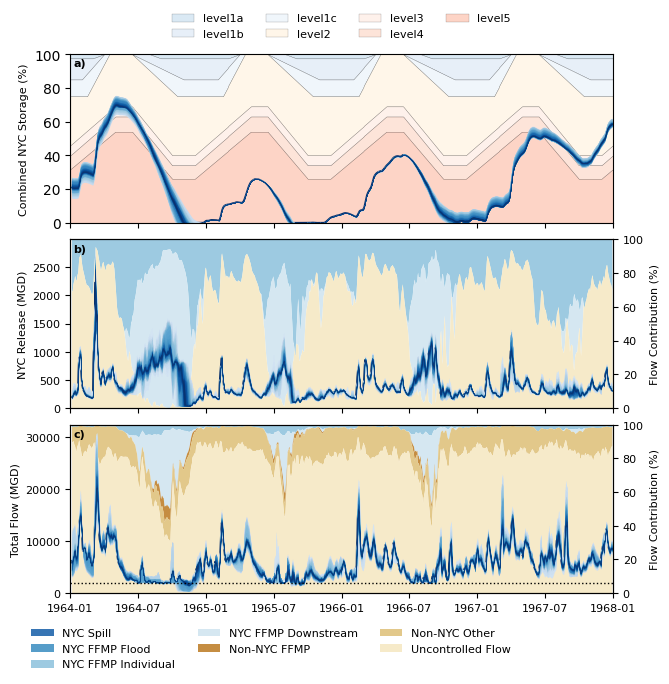

In [7]:
plot_NYC_release_components_combined(storages, 
                                     ffmp_level_boundaries=ffmp_levels['pywr_obs_pub_nwmv21_ObsScaled'],
                                     model = 'pywr_obs_pub_nwmv21_ObsScaled_ensemble', 
                                     node = 'delTrenton',
                                     nyc_release_components=nyc_releases,
                                     lower_basin_mrf_contributions=lower_basin_mrf_contributions,
                                     reservoir_releases=reservoir_releases,
                                     reservoir_downstream_gages=reservoir_downstream_gages,
                                     major_flows=major_flows,
                                     inflows=reservoir_inflows,
                                     diversions=ibt_diversions,
                                     consumptions=catchment_consumptions,
                                     colordict=model_colors_historic_reconstruction,
                                     start_date=pd.to_datetime(start_1960s_drought), 
                                     end_date=pd.to_datetime('1968-01-01'),
                                     plot_observed=False,
                                     percentile_cmap=True,
                                     contribution_fill_alpha=0.9,
                                     plot_flow_target=True,
                                     use_log=False,
                                     q_lower_bound=0.01, 
                                     q_upper_bound=0.99,
                                     smoothing_window=7,
                                     fig_dir=fig_dir)

C:\Users\tjame\AppData\Local\Temp\ipykernel_22792\3475098013.py:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  level_colors = [cm.get_cmap('Blues')(v) for v in [0.3, 0.2, 0.1]] +\
C:\Users\tjame\AppData\Local\Temp\ipykernel_22792\3475098013.py:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  [cm.get_cmap('Reds')(v) for v in [0.1, 0.2, 0.3]]
C:\Users\tjame\AppData\Local\Temp\ipykernel_22792\3475098013.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = pl

Max NYC contribution perc: 100.00000000000003


C:\Users\tjame\AppData\Local\Temp\ipykernel_22792\3475098013.py:457: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)
C:\Users\tjame\AppData\Local\Temp\ipykernel_22792\3475098013.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap(cmap_name)
C:\Users\tjame\AppData\Local\Temp\ipykernel_22792\3475098013.py:638: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nyc_release_contributions[r] = np.maximum(non_nyc_release_contributions[r] -
C:\Users\tjame\AppData\L

Inflows from: Index(['01425000', '01417000', 'delLordville', '01436000', '01433500',
       'delMontague', '01449800', '01447800', 'delDRCanal'],
      dtype='object')
Non-NYC releases from: Index(['prompton', 'wallenpaupack', 'shoholaMarsh', 'mongaupeCombined',
       'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong',
       'nockamixon'],
      dtype='object')
Lower basin MRF contributions from: Index(['beltzvilleCombined', 'blueMarsh', 'nockamixon'], dtype='object')
NYC FFMP target individuals from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC FFMP montagueTrentons from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC FFMP flood releases from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC spills from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
Max flow contribution perc: 100.00000000000004 at index 2018-05-19 00:00:00
Error at 2018-05-19 00:00:00: 73.77163869301135, 18.2550520234276

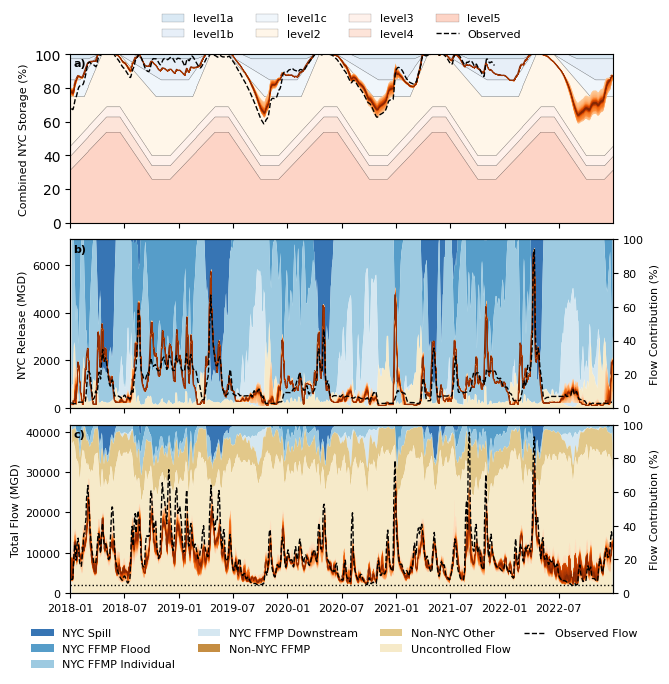

In [20]:
plot_NYC_release_components_combined(storages, 
                                     ffmp_level_boundaries=ffmp_levels['pywr_obs_pub_nwmv21_ObsScaled'],
                                     model = 'pywr_obs_pub_nhmv10_ObsScaled_ensemble', 
                                     node = 'delTrenton',
                                     nyc_release_components=nyc_releases,
                                     lower_basin_mrf_contributions=lower_basin_mrf_contributions,
                                     reservoir_releases=reservoir_releases,
                                     reservoir_downstream_gages=reservoir_downstream_gages,
                                     major_flows=major_flows,
                                     inflows=reservoir_inflows,
                                     diversions=ibt_diversions,
                                     consumptions=catchment_consumptions,
                                     colordict=model_colors_historic_reconstruction,
                                     start_date=pd.to_datetime('2018-01-01'), 
                                     end_date=pd.to_datetime('2022-12-31'),
                                     plot_observed=True,
                                     percentile_cmap=True,
                                     contribution_fill_alpha=0.9,
                                     plot_flow_target=True,
                                     use_log=False,
                                     q_lower_bound=0.001,
                                     q_upper_bound=0.999,
                                     smoothing_window=7,
                                     fig_dir=fig_dir, fig_dpi=350)

In [28]:
# This function takes two state variables and plots a heatmap of the relative occurence of each state acorss simulation
# If the model is of the type 'ensemble' then we get the occurence across realizations and timeseries.  If not then occurence across the timseries

# First make a function to generate a grid of relative percent occurences


def get_statespace_bins(data1, data2, model, node1, node2, n_bins=100):
        
    is_ensemble = True if 'ensemble' in model else False
    
    use_model_minmax = model.split('_ensemble')[0] if is_ensemble else model
     
    x1_min = 0.0 # data1[use_model_minmax][node1].min()
    x1_max = data1[use_model_minmax][node1].quantile(0.9)
    x2_min = 0.0 # data2[use_model_minmax][node2].min()
    x2_max = data2[use_model_minmax][node2].quantile(0.9)

    # Get bins for each variable
    x1_bins = np.linspace(x1_min, x1_max, n_bins)
    x2_bins = np.linspace(x2_min, x2_max, n_bins)
    
    return x1_bins, x2_bins
    


def get_statespace_occurence_grid(data1, data2, 
                                  model, 
                                  node1, node2, 
                                  n_bins=100):
    """
    Gets the percentage occurence of each state in the state space of two variables
    across realizations and time. 
    
    Args:
        data1 (dict): pywrdrb results dictionary of first variable
        data2 (dict): pywrdrb results dictionary of second variable 
        model (str): Model name
        node1 (str): Name of the node (e.g., cannonsville) to be taken from data1
        node2 (str): Name of the node (e.g., delTrenton) to be taken from data2
    
    Returns:
        occurence_grid (np.array): 2D array of percent occurence of each state in the state space
    """
    is_ensemble = True if 'ensemble' in model else False

    occurence_grid = np.zeros((n_bins, n_bins))

    x1_bins, x2_bins = get_statespace_bins(data1, data2, 
                                           model, 
                                           node1, node2, 
                                           n_bins=n_bins)
    
    if is_ensemble:
        realizations = list(data1[model].keys())
        
        for real in realizations:
                        
            x1_indices = np.digitize(data1[model][real][node1], x1_bins)
            x2_indices = np.digitize(data2[model][real][node2], x2_bins)
            
            # store the occurence of each state in the state space
            for i in range(len(x1_indices)):
                occurence_grid[x1_indices[i]-1, x2_indices[i]-1] += 1
                
        # Normalize by the total number of states
        occurence_grid = occurence_grid / occurence_grid.sum()
        
    else:
        x1_indices = np.digitize(data1[model][node1], x1_bins)
        x2_indices = np.digitize(data2[model][node2], x2_bins)
        
        for i in range(len(x1_indices)):
            occurence_grid[x1_indices[i]-1, x2_indices[i]-1] += 1
        
        occurence_grid = occurence_grid / occurence_grid.sum()
    
    return occurence_grid



start_1960s_drought = '1963-01-01'
end_1960s_drought = '1967-12-31'

model = 'pywr_obs_pub_nwmv21_ObsScaled_ensemble'

is_ensemble = True if 'ensemble' in model else False

if is_ensemble:
    for real in storages[model].keys():
        storages[model][real]['NYCTotal'] = storages[model][real][reservoir_list_nyc].sum(axis=1) / nyc_reservoir_capacities['NYCTotal'] * 100
else:
    storages[model]['NYCTotal'] = storages[model][reservoir_list_nyc].sum(axis=1) / nyc_reservoir_capacities['NYCTotal'] * 100
    

x1_bins, x2_bins = get_statespace_bins(storages, major_flows,
                                        model, 
                                        'NYCTotal', 'delTrenton', 
                                        n_bins=20)

test_states = get_statespace_occurence_grid(storages, major_flows, 
                                            model, 
                                            'NYCTotal', 'delTrenton', 
                                            n_bins=20)


fig = plt.figure(figsize=(7,7), dpi=150)
ax = fig.add_subplot(1,1,1)


ax.imshow(test_states, 
           cmap='viridis_r',
           origin='lower')

# add colormap for imshow
cmap = plt.cm.viridis_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0,1,11), 
             label='Relative State Occurence\nAcross Ensembles')
cbar.ax.tick_params(labelsize=12)

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])


# Overlay a connected point scatter plot of statespace timeseries
# for period of 1964-1965

start_subset = '1964-04-01'
end_subset = '1964-12-31'

model = 'pywr_obs_pub_nwmv21_ObsScaled'

### Ax2: Statespace timeseries
# Pull data
subset_storage = subset_timeseries(storages[model], start_subset, end_subset)
subset_majorflows = subset_timeseries(major_flows[model], start_subset, end_subset)


subset_storage = subset_timeseries(storages[model], start_subset, end_subset)
subset_majorflows = subset_timeseries(major_flows[model], start_subset, end_subset)
subset_mrf_targets = subset_timeseries(ffmp_mrf_requirements[model], start_subset, end_subset)

percent_total_nyc_storage = subset_storage.loc[:, reservoir_list_nyc].sum(axis=1) / nyc_reservoir_capacities['NYCTotal'] * 100

# get rolling average with window size N
window = 30
roll_percent_total_nyc_storage = percent_total_nyc_storage.rolling(window).mean().dropna()
roll_major_flow = subset_majorflows['delTrenton'].rolling(window).mean().dropna()
roll_mrf_targets = subset_mrf_targets[['delMontague', 'delTrenton', 'individual_agg_nyc']].sum(axis=1).rolling(window).mean().dropna()

max_mrf_target = roll_mrf_targets.max()
min_mrf_target = roll_mrf_targets.min()
norm_roll_mrf_targets = (roll_mrf_targets - min_mrf_target) / (max_mrf_target - min_mrf_target) 

n_segments = len(roll_major_flow) // 50
dt_segments = len(roll_major_flow) // n_segments
min_segment_lw = 1

ax2 = fig.add_axes(ax.get_position(), frameon=False, zorder=5)

# Plot line segments using total downstream ffmp requirement as thickness
for i in range(n_segments):
    norm_segment_mrf_target = norm_roll_mrf_targets[i*dt_segments:(i+1)*dt_segments].values[0]
    segment_lw = norm_segment_mrf_target * 30
    if segment_lw <= 0.1:
        segment_lw = min_segment_lw
        segment_ls = '--'        
    else:
        segment_ls = '-'
        
    ax2.plot(roll_major_flow[i*dt_segments:(i+1)*dt_segments],
                roll_percent_total_nyc_storage[i*dt_segments:(i+1)*dt_segments], 
                color='red', 
                lw= segment_lw,
                ls=segment_ls, 
                alpha = 1)

# Add scatter points for specific dates of interest
# Include points for the start date and end date
ax2.scatter(roll_major_flow[0], roll_percent_total_nyc_storage[0], 
            s=100, marker='o', color='black', zorder=10)
ax2.scatter(roll_major_flow[-1], roll_percent_total_nyc_storage[-1],
            s=100, marker='o', color='black', zorder=10)

# Add text at date points
ax2.text(roll_major_flow[0], roll_percent_total_nyc_storage[0] - 2, 
         start_subset, ha='right', va='top', fontsize=12)
ax2.text(roll_major_flow[-1], roll_percent_total_nyc_storage[-1] + 2,
            end_subset, ha='left', va='bottom', fontsize=12)


ax2.set_ylim(0, 100)
ax2.set_xlim(0, x2_bins[-1])

plt.ylabel('NYC Total Storage (%)', fontsize = 12)
plt.xlabel('Flow at Trenton (MGD)', fontsize=12)


KeyError: 'NYCTotal'

In [53]:
import datetime

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize, LogNorm, ListedColormap, BoundaryNorm, LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from scipy import stats
import sys


import hydroeval as he
import h5py
import datetime as dt

from pywrdrb.pywr_drb_node_data import upstream_nodes_dict, downstream_node_lags, immediate_downstream_nodes_dict

# Custom modules
from pywrdrb.utils.constants import cms_to_mgd, cm_to_mg, cfs_to_mgd
from pywrdrb.utils.lists import reservoir_list, reservoir_list_nyc, majorflow_list, reservoir_link_pairs, seasons_dict
from pywrdrb.utils.lists import drbc_lower_basin_reservoirs
from pywrdrb.utils.directories import input_dir, fig_dir, output_dir, model_data_dir
from pywrdrb.make_model import get_reservoir_max_release
from pywrdrb.plotting.styles import base_model_colors, model_hatch_styles, paired_model_colors, scatter_model_markers, \
    node_label_dict, node_label_full_dict, model_label_dict, month_dict, model_linestyle_dict




### function to return subset of dates for timeseries data
def subset_timeseries(timeseries, start_date, end_date, end_inclusive=True):
    data = timeseries.copy()
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
    if not end_inclusive:
        end_date = end_date - dt.timedelta(days=1)

    if start_date is not None:
        data = data.loc[start_date:]
    if end_date is not None:
        data = data.loc[:end_date]
    return data


## This new version includes lower basin contributions
def new_plot_NYC_release_components_combined(nyc_release_components,
                                             lower_basin_mrf_contributions, 
                                             reservoir_releases, major_flows, inflows, diversions,
                                         consumptions, model, node, start_date = None, end_date = None,
                                         use_proportional=False, use_log=False, fig_dir=fig_dir):
    
    target = delTrenton_target if node == 'delTrenton' else delMontague_target
    
    fig, axs = plt.subplots(2,1,figsize=(12,6), dpi=300)

    ### subfig a: first split up NYC releases into components
    release_total = subset_timeseries(reservoir_releases[model][reservoir_list_nyc], start_date, end_date).sum(axis=1)
    x = release_total.index
    if use_proportional:
        ax2 = axs[0]
        ax2.plot(release_total, color='k', lw=1)
        ax2.set_xlim([x[0], x[-1]])
        ax = ax2.twinx()
        ax.set_ylim([0,100])

        if use_log:
            ax2.semilogy()

    else:
        ax = axs[0]
        ax.plot(release_total, color='k', lw=1)
        ax.set_xlim([x[0], x[-1]])
        if use_log:
            ax.semilogy()

    ### colorbrewer brown/teal palette https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=4
    colors = ['#01665e', '#35978f', '#80cdc1', '#c7eae5', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a']
    alpha = 1


    release_components_full = subset_timeseries(nyc_release_components[model], start_date, end_date)
    release_types = ['mrf_target_individual', 'mrf_montagueTrenton', 'flood_release', 'spill']
    release_components = pd.DataFrame({release_type: release_components_full[[c for c in release_components_full.columns if release_type in c]].sum(axis=1) for release_type in release_types})

    lower_basin_mrf_contributions = subset_timeseries(lower_basin_mrf_contributions[model], start_date, end_date)
    lower_basin_mrf_contributions.columns = [c.split('_')[-1] for c in lower_basin_mrf_contributions.columns]
    
    if use_proportional:
        release_components = release_components.divide(release_total, axis=0) * 100

    y1 = 0
    y2 = y1 + release_components[f'mrf_montagueTrenton'].values
    y3 = y2 + release_components[f'mrf_target_individual'].values
    y4 = y3 + release_components[f'flood_release'].values
    y5 = y4 + release_components[f'spill'].values
    print(f'Max contribution: {y5.max()}')
    ax.fill_between(x, y4, y5, label='NYC Spill', color=colors[0], alpha=alpha)
    ax.fill_between(x, y3, y4, label='NYC FFMP Flood', color=colors[1], alpha=alpha)
    ax.fill_between(x, y2, y3, label='NYC FFMP Individual', color=colors[2], alpha=alpha)
    ax.fill_between(x, y1, y2, label='NYC FFMP Downstream', color=colors[3], alpha=alpha)

    if use_proportional:
        ax2.set_ylabel('Total Release (MGD)')
        ax.set_ylabel('Release Contribution (%)')
    else:
        ax.set_ylabel('Total Release (MGD)')


    if use_proportional:
        ax.set_zorder(1)
        ax2.set_zorder(2)
        ax2.patch.set_visible(False)

    ### subfig b: split up trenton flow into components

    # Get total sim and obs flow
    total_sim_node_flow = subset_timeseries(major_flows[model][node], start_date, end_date)

    ### for Trenton, we use "Trenton Equivalent Flow" 
    # add NJ diversion to simulated flow
    # add blueMarsh MRF contribution (not connected in simulated but is included in "equivelent flow")
    if node == 'delTrenton':
        nj_diversion = subset_timeseries(diversions[model]['delivery_nj'], start_date, end_date)
        total_sim_node_flow += nj_diversion
        
        blueMarsh_mrf_contribution = subset_timeseries(lower_basin_mrf_contributions['blueMarsh'], start_date, end_date)
        total_sim_node_flow += blueMarsh_mrf_contribution

    # Get shortage from target
    shortage =  -(total_sim_node_flow - target)
    shortage[shortage < 0] = 0
    
    
    
    if use_proportional:
        ax2 = axs[1]
        ax2.plot(total_sim_node_flow, color='k', lw=1)
        ax2.hlines(target, x[0], x[-1], color='r', linestyle='--', lw=1, label='Target', zorder=10)
        ax = ax2.twinx()
        ax.set_ylim([0,100]) 
        ax.set_xlim(total_sim_node_flow.index[0], total_sim_node_flow.index[-1])
        if use_log:
            ax2.semilogy()

        ax2.set_ylabel('Total Flow (MGD)')
        ax.set_ylabel('Flow Contribution (%)')
    else:
        ax = axs[1]
        ax.plot(total_sim_node_flow, color='k', lw=1)
        ax.set_ylabel('Total Release (MGD)')


    # Get contributing flows
    contributing = upstream_nodes_dict[node]
    non_nyc_reservoirs = [i for i in contributing if (i in reservoir_list) and (i not in reservoir_list_nyc)]
    
    non_nyc_release_contributions = reservoir_releases[model][non_nyc_reservoirs]         
        
    use_inflows = [i for i in contributing if (i in majorflow_list)]
    if node == 'delMontague':
        use_inflows.append('delMontague')
    inflow_contributions = inflows[model][use_inflows] - consumptions[model][use_inflows]
    mrf_target_individuals = nyc_release_components[model][[c for c in nyc_release_components[model].columns if 'mrf_target_individual' in c]]
    mrf_target_individuals.columns = [c.rsplit('_',1)[1] for c in mrf_target_individuals.columns]
    mrf_montagueTrentons = nyc_release_components[model][[c for c in nyc_release_components[model].columns if 'mrf_montagueTrenton' in c]]
    mrf_montagueTrentons.columns = [c.rsplit('_',1)[1] for c in mrf_montagueTrentons.columns]
    flood_releases = nyc_release_components[model][[c for c in nyc_release_components[model].columns if 'flood_release' in c]]
    flood_releases.columns = [c.rsplit('_',1)[1] for c in flood_releases.columns]
    spills = nyc_release_components[model][[c for c in nyc_release_components[model].columns if 'spill' in c]]
    spills.columns = [c.rsplit('_',1)[1] for c in spills.columns]


    # Impose lag
    for c in upstream_nodes_dict[node][::-1]:
        if c in inflow_contributions.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                inflow_contributions[c].iloc[lag:] = inflow_contributions[c].iloc[:-lag]
        elif c in non_nyc_release_contributions.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                non_nyc_release_contributions[c].iloc[lag:] = non_nyc_release_contributions[c].iloc[:-lag]
        elif c in mrf_target_individuals.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                mrf_target_individuals[c].iloc[lag:] = mrf_target_individuals[c].iloc[:-lag]
                mrf_montagueTrentons[c].iloc[lag:] = mrf_montagueTrentons[c].iloc[:-lag]
                flood_releases[c].iloc[lag:] = flood_releases[c].iloc[:-lag]
                spills[c].iloc[lag:] = spills[c].iloc[:-lag]
        elif c in lower_basin_mrf_contributions.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                lower_basin_mrf_contributions[c].iloc[lag:] = lower_basin_mrf_contributions[c].iloc[:-lag]
                


    inflow_contributions = subset_timeseries(inflow_contributions, start_date, end_date).sum(axis=1)
    non_nyc_release_contributions = subset_timeseries(non_nyc_release_contributions, start_date, end_date).sum(axis=1)
    mrf_target_individuals = subset_timeseries(mrf_target_individuals, start_date, end_date).sum(axis=1)
    mrf_montagueTrentons = subset_timeseries(mrf_montagueTrentons, start_date, end_date).sum(axis=1)
    flood_releases = subset_timeseries(flood_releases, start_date, end_date).sum(axis=1)
    spills = subset_timeseries(spills, start_date, end_date).sum(axis=1)
    lower_basin_mrf_contributions = subset_timeseries(lower_basin_mrf_contributions, start_date, end_date).sum(axis=1)
    shortage = subset_timeseries(shortage, start_date, end_date)
    print(f'Shortage: {shortage.shape}')
    print(f'Shortage nas: {shortage.isna().sum()}')
    if use_proportional:
        inflow_contributions = inflow_contributions.divide(total_sim_node_flow+shortage) * 100
        non_nyc_release_contributions = non_nyc_release_contributions.divide(total_sim_node_flow+shortage) * 100
        mrf_target_individuals = mrf_target_individuals.divide(total_sim_node_flow+shortage) * 100
        mrf_montagueTrentons = mrf_montagueTrentons.divide(total_sim_node_flow+shortage) * 100
        flood_releases = flood_releases.divide(total_sim_node_flow+shortage) * 100
        spills = spills.divide(total_sim_node_flow+shortage) * 100
        lower_basin_mrf_contributions = lower_basin_mrf_contributions.divide(total_sim_node_flow+shortage) * 100
        shortage = shortage.divide(total_sim_node_flow+shortage) * 100

    y1 = 0
    y2 = y1 + inflow_contributions
    y3 = y2 + non_nyc_release_contributions
    y3_5 = y3 + lower_basin_mrf_contributions
    y4 = y3_5 + mrf_montagueTrentons
    y5 = y4 + mrf_target_individuals
    y6 = y5 + flood_releases
    y7 = y6 + spills
    y8 = y7 + shortage
    print(f'Max contribution perc: {y8.max()}')
    ax.fill_between(x, y6, y7, label='NYC Spill', color=colors[0], alpha=alpha)
    ax.fill_between(x, y5, y6, label='NYC FFMP Flood', color=colors[1], alpha=alpha)
    ax.fill_between(x, y4, y5, label='NYC FFMP Individual', color=colors[2], alpha=alpha)
    ax.fill_between(x, y3_5, y4, label='NYC FFMP Downstream', color=colors[3], alpha=alpha)
    ax.fill_between(x, y3, y3_5, label = 'Lower Basin FFMP', color = 'purple', alpha=alpha, linewidth = 0.0)
    ax.fill_between(x, y2, y3, label='Non-NYC Release', color=colors[5], alpha=alpha)
    ax.fill_between(x, y1, y2, label='Uncontrolled Flow', color=colors[4], alpha=alpha)
    ax.fill_between(x, y7, y8, label='Shortage', color='maroon', alpha=alpha, linewidth = 0.0)
    
    
    ax.legend(frameon=False, loc='center', bbox_to_anchor=(0.5, -0.3), ncols=3)

    if use_proportional:
        ax.set_zorder(1)
        ax2.set_zorder(2)
        ax2.patch.set_visible(False)



    plt.savefig(f'{fig_dir}NYC_release_components_combined_{model}_{node}_' + \
                f'{release_total.index.year[0]}_{release_total.index.year[-1]}.png',
                bbox_inches='tight', dpi=500)
    return shortage


Max contribution: 100.00000000000003
Shortage: (1097,)
Shortage nas: 0
Max contribution perc: 100.32327471380152


C:\Users\tjame\AppData\Local\Temp\ipykernel_28176\73766727.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nyc_release_contributions[c].iloc[lag:] = non_nyc_release_contributions[c].iloc[:-lag]
C:\Users\tjame\AppData\Local\Temp\ipykernel_28176\73766727.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrf_target_individuals[c].iloc[lag:] = mrf_target_individuals[c].iloc[:-lag]
C:\Users\tjame\AppData\Local\Temp\ipykernel_28176\73766727.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\tjame\\Desktop\\Research\\DRB\\Pywr-DRB\\Pywr-DRB\\figs//full_reconstruction/NYC_release_components_combined_pywr_obs_pub_nhmv10_ObsScaled_delTrenton_1964_1967.png'

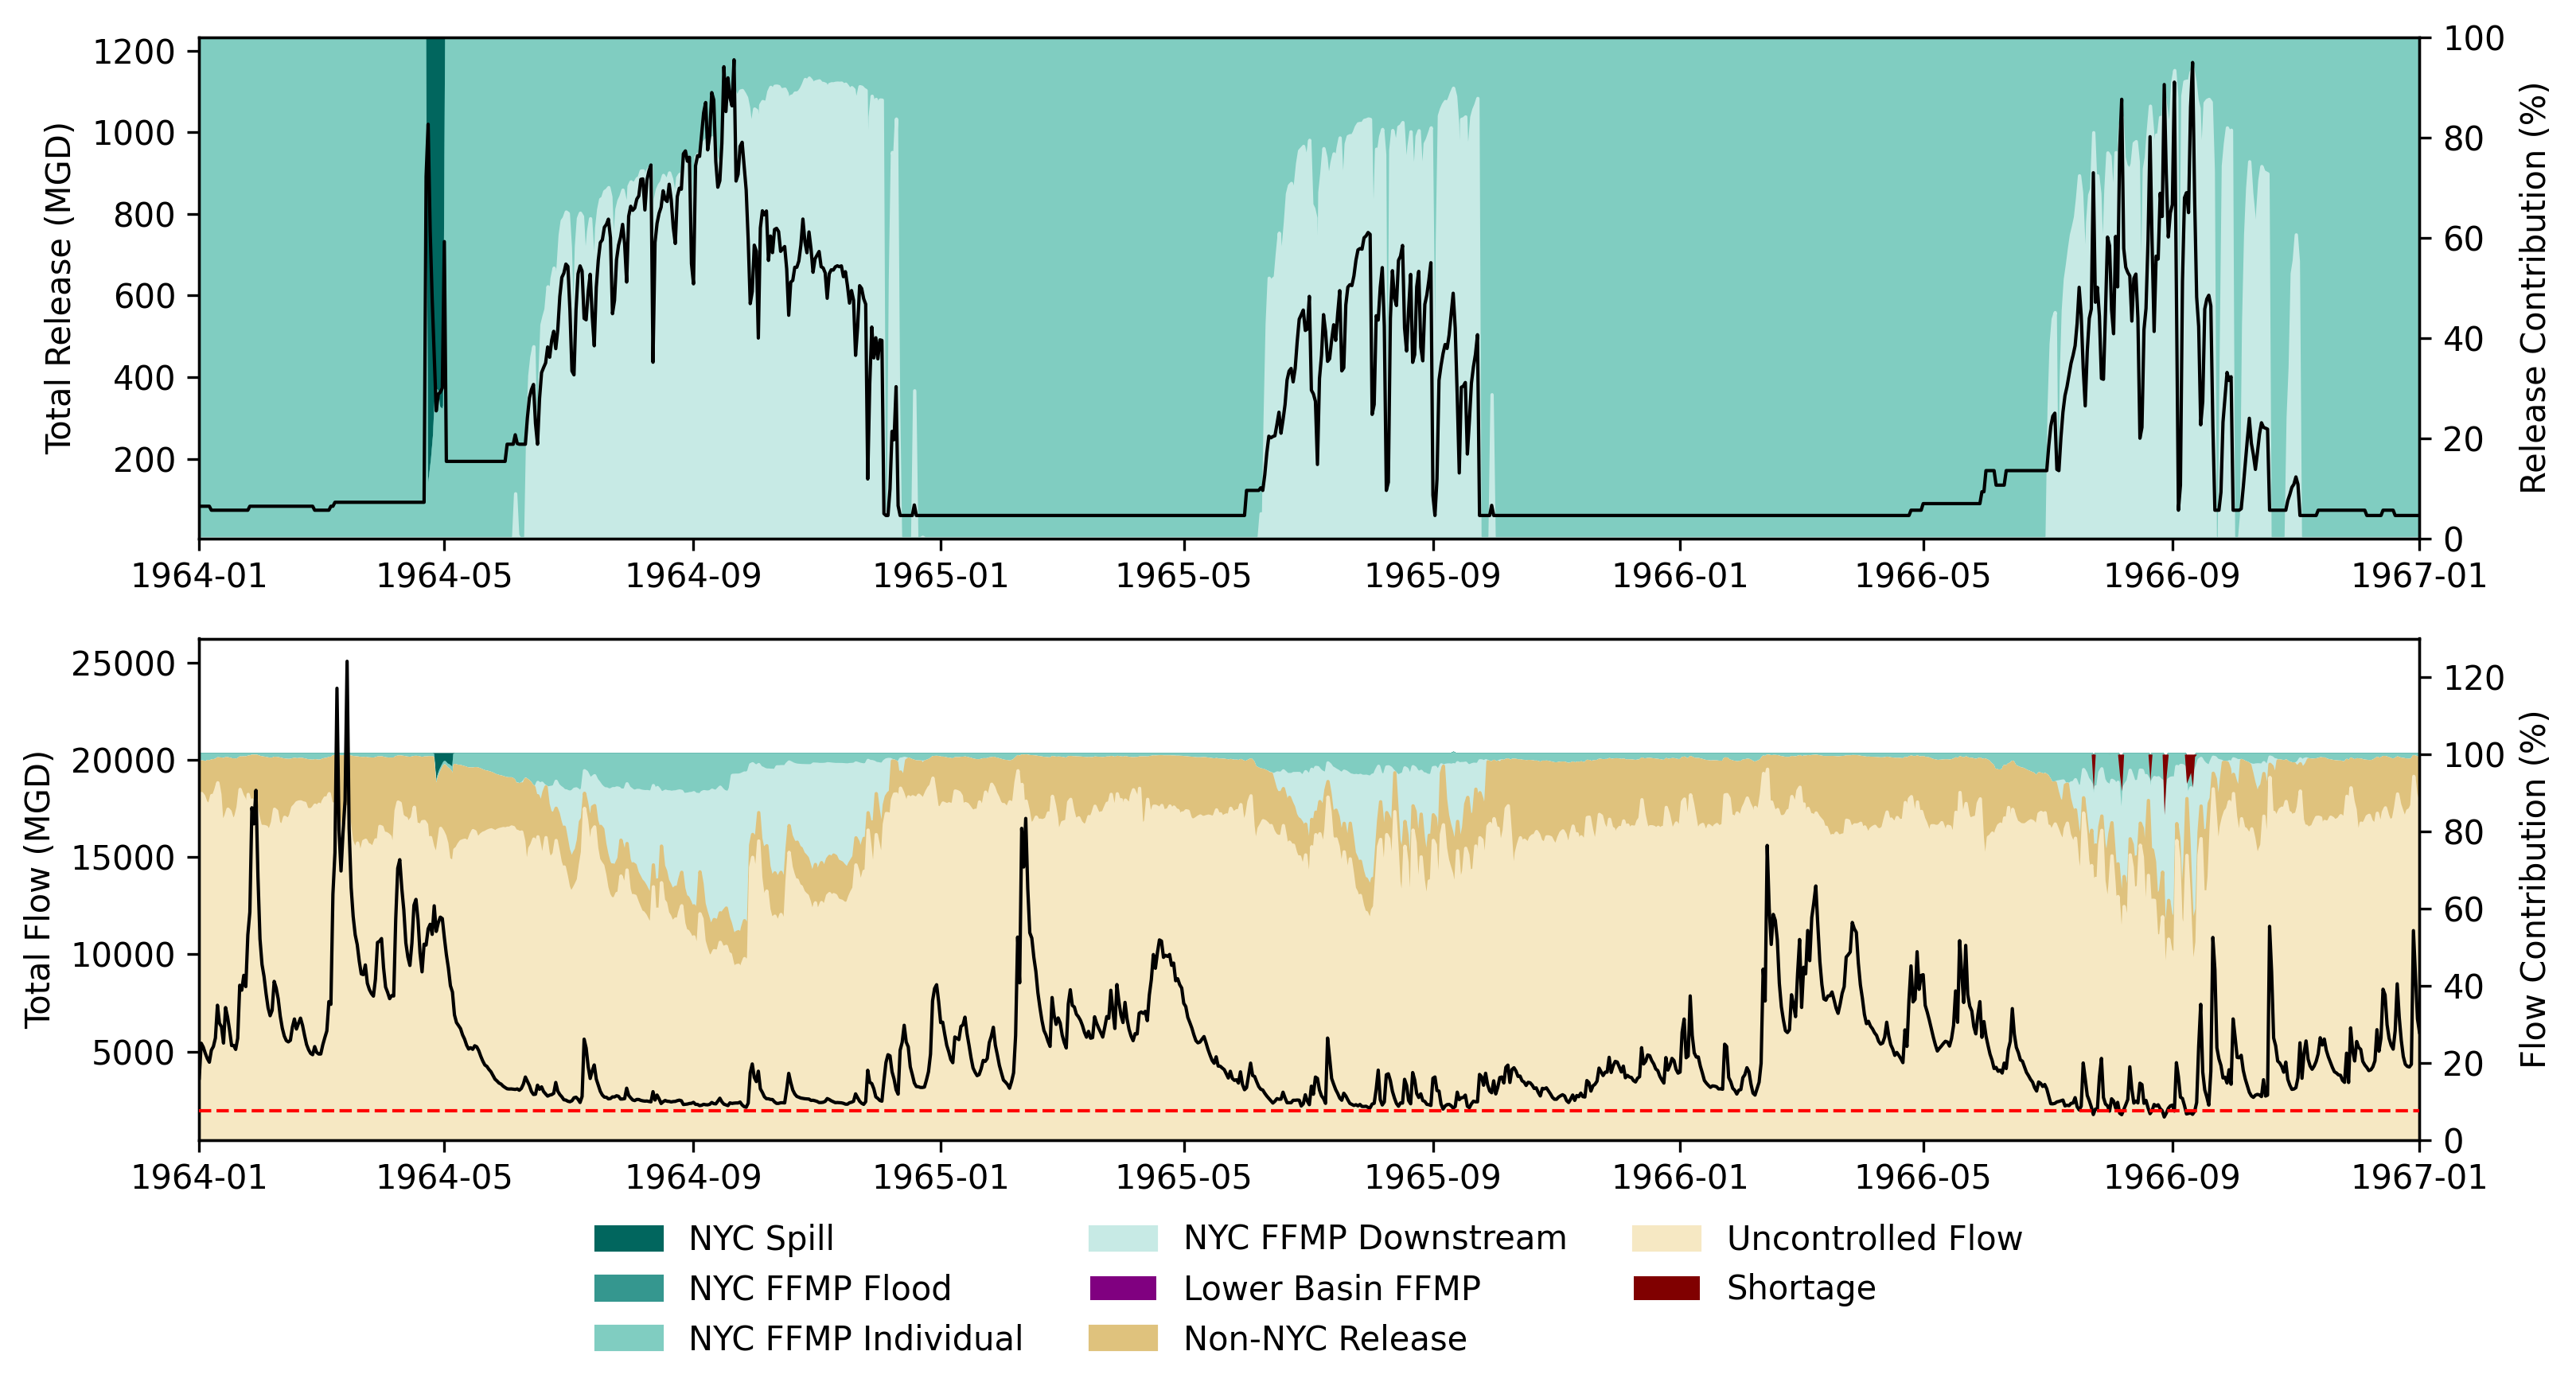

In [54]:

for model in ['pywr_obs_pub_nhmv10_ObsScaled', 'pywr_obs_pub_nwmv21_ObsScaled']:
    for node in ['delTrenton', 'delMontague']:
        new_plot_NYC_release_components_combined(nyc_releases, 
                                                lower_basin_mrf_contributions, 
                                                reservoir_releases,
                                                major_flows,
                                                reservoir_inflows, 
                                                ibt_diversions, 
                                                catchment_consumptions, 
                                                model = model,
                                                node = node, 
                                                start_date = start_1960s_drought,
                                                end_date = end_1960s_drought,
                                                fig_dir = fig_dir+ '/full_reconstruction/', 
                                                use_proportional=True)

        new_plot_NYC_release_components_combined(nyc_releases, 
                                                lower_basin_mrf_contributions, 
                                                reservoir_releases,
                                                major_flows,
                                                reservoir_inflows, 
                                                ibt_diversions, 
                                                catchment_consumptions, 
                                                model = model,
                                                node = node, 
                                                start_date = start_1980s_drought,
                                                end_date = end_1980s_drought,
                                                fig_dir = fig_dir+ '/full_reconstruction/', 
                                                use_proportional=True)


[5, 5, 5]

In [80]:
    ### plot breaking down NYC flows & Trenton flows into components

print('Plotting NYC releases by components, combined with downstream flow components')
for model in pywr_models:
    for node in ['delMontague','delTrenton']:
        plot_NYC_release_components_combined(nyc_release_components, reservoir_releases, major_flows, inflows,
                                                ibt_diversions, catchment_consumptions, model, node,
                                                use_proportional=True, use_log=True,
                                                start_date=start_date_short_preobs, end_date=end_date_short_preobs,
                                                fig_dir=fig_dir)

,mrf_target_individual_cannonsville,mrf_target_individual_pepacton,mrf_target_individual_neversink,flood_release_cannonsville,flood_release_pepacton,flood_release_neversink,mrf_montagueTrenton_cannonsville,mrf_montagueTrenton_pepacton,mrf_montagueTrenton_neversink,spill_cannonsville,spill_pepacton,spill_neversink
1952-01-01,54.936842,45.241,32.313333,0.0,0.0,0.0,597.649959,0.000000,0.0,0.000000e+00,0.000000e+00,0.0
1952-01-02,54.936842,45.241,32.313333,0.0,0.0,0.0,797.595087,0.000000,0.0,0.000000e+00,0.000000e+00,0.0
1952-01-03,54.936842,45.241,32.313333,0.0,0.0,0.0,727.560463,0.000000,0.0,0.000000e+00,0.000000e+00,0.0
1952-01-04,54.936842,45.241,32.313333,0.0,0.0,0.0,605.542994,0.000000,0.0,0.000000e+00,0.000000e+00,0.0
1952-01-05,54.936842,45.241,32.313333,0.0,0.0,0.0,518.283317,90.560289,0.0,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,54.936842,45.241,32.313333,0.0,0.0,0.0,261.695864,0.000000,0.0,-1.762146e-12,4.199308e-12,0.0
2022-12-28,54.936842,45.241,32.313333,0.0,0.0,0.0,222.753313,0.000000,0.0,-2.842171e-13,2.039258e-12,0.0
2022-12-29,54.936842,45.241,32.313333,0.0,0.0,0.0,193.204093,0.000000,0.0,3.410605e-13,3.517187e-12,0.0
2022-12-30,54.936842,45.241,32.313333,0.0,0.0,0.0,176.337656,0.000000,0.0,-1.989520e-12,1.698197e-12,0.0


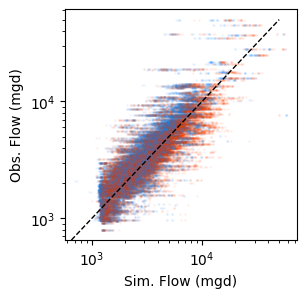

In [103]:
def plot_ensemble_scatter(results, models, node, start_date, end_date,
                             plot_individual_realizations=False, plot_ensemble_median=True,
                             plot_observed=True, fill_between_quantiles= True, 
                             plot_nhm= False, plot_nwm= False,
                             fill_between=True, fill_alpha=0.2,
                             log_y = False, plot_flow_target=False):
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    # Get ensemble realization numbers
    ensemble_realizations = list(results[models[0]].keys())

    # Re-arrange data from all realiztions into single dataframe
    for i,real in enumerate(ensemble_realizations):

        for model in models:
            model_color = model_colors[model.replace('pywr_', '')]
            
            assert(model in results.keys()), f'{model} not in results dictionary.'



            Q_obs = results['obs'][node].loc[start_date:end_date].dropna()
            
            Q_sim = results[model][real][node].loc[Q_obs.index]
            
            ax.scatter(Q_sim, Q_obs, color=model_color, alpha=0.05, s=1)


    # Add 1-1 line
    ax.plot([0, 50000], [0, 50000], color='k', linestyle='--', linewidth=1)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Obs. Flow (mgd)')
    ax.set_xlabel('Sim. Flow (mgd)')
    return 


plot_start_date= '2019-10-01'
plot_end_date = '2022-12-31'
plot_ensemble_scatter(major_flows, ['pywr_obs_pub_nwmv21_ObsScaled_ensemble', 'pywr_obs_pub_nhmv10_ObsScaled_ensemble'],
                         'delMontague', plot_start_date, plot_end_date,
                         plot_individual_realizations=False, plot_ensemble_median=False, fill_between=False,
                         fill_between_quantiles=True, 
                         fill_alpha=0.5,
                         plot_observed=True, plot_nhm=False, plot_nwm=False,
                         log_y=False, plot_flow_target=True)


In [7]:
    
def get_ensemble_error_metrics(ensemble_results, observed_results, model, node):
    """
    Generate error metrics (NSE, KGE, correlation, bias, etc.) for 
    each realization in an ensemble at a specific node for specific model.

    Args:
        ensemble_results (dict): A dictionary containing dataframes of results.
        observed_results (pandas.DataFrame): A dataframe containing observed flow data.
        models (list): A list of model names (str) to compute error metrics for.
        nodes (list): A list of node names (str) to compute error metrics for.

    Returns:
        pd.DataFrame: A dataframe containing error metrics for the specified models and nodes.
    """
    # assert('ensemble' in model), 'The model dataset must be an ensemble, with "ensemble" in the name'
    assert('realization_' in list(ensemble_results.keys())[0]), 'ensemble_results[model] must be a dict of Dfs with keys of the form "realization_#"'
    
    ensemble_results_metrics = {}
    
    ### compile error across models/nodes/ensemble/metrics
    for i, real in enumerate(list(ensemble_results.keys())):

        obs = observed_results[node]
        modeled = ensemble_results[real][node]

        ### only do models with nonzero entries (eg remove some weap)
        if np.sum(modeled) > 0:
            ### get kge & nse
            kge, r, alpha, beta = he.evaluator(he.kge, modeled, obs)
            nse = he.evaluator(he.nse, modeled, obs)
            logkge, logr, logalpha, logbeta = he.evaluator(he.kge, modeled, obs, transform='log')
            lognse = he.evaluator(he.nse, modeled, obs, transform='log')

            ### get Kolmogorov-Smirnov Statistic, & metric is 1 minus this (1 in ideal case, 0 in worst case)
            kss, _ = stats.ks_2samp(modeled, obs)
            kss = 1 - kss

            resultsdict = {'nse': nse[0], 'kge': kge[0], 'r': r[0], 'alpha': alpha[0], 'beta': beta[0],
                        'lognse': lognse[0], 'logkge': logkge[0], 'logr': logr[0], 'logalpha': logalpha[0],
                        'logbeta': logbeta[0], 'kss': kss}

            resultsdict['node'] = node
            resultsdict['realization'] = int(real.split('_')[-1])
            
            if i == 0:
                ensemble_results_metrics = pd.DataFrame(resultsdict, index=[0])
            else:
                ensemble_results_metrics = pd.concat([ensemble_results_metrics, pd.DataFrame(resultsdict, index=[0])])
                
        # Set the 'realization' column as the index and remove old
    ensemble_results_metrics.set_index('realization', inplace=True)
                
    return ensemble_results_metrics

In [8]:
def get_ensemble_RRV_metrics(ensemble_results, observed_results, node):
    """
    Calculate measures of reliability, resilience, and vulnerability based on Hashimoto et al. (1982) WRR.

    Args:
        results (dict): Dictionary containing model results for different nodes.
        models (list): List of model names (str) to include in the analysis.
        nodes (list): List of node names (str) to include in the analysis.

    Returns:
        pd.DataFrame: DataFrame containing reliability, resiliency, and vulnerability metrics for each model and node.
    """
    thresholds = {'delMontague': 1131.05, 'delTrenton': 1938.950669}  ### FFMP flow targets (MGD)
    eps = 1e-9
    thresholds = {k: v - eps for k, v in thresholds.items()}
    
    assert('realization_' in list(ensemble_results.keys())[0]), 'ensemble_results[model] must be a dict of Dfs with keys of the form "realization_#"'
    
    ### compile error across models/nodes/ensemble/metrics
    for i, real in enumerate(list(ensemble_results.keys())):

        obs = observed_results[node]
        modeled = ensemble_results[real][node]

        ### only do models with nonzero entries (eg remove some weap)
        if np.sum(modeled) > 0:
            ### reliability is the fraction of time steps above threshold
            reliability = (modeled > thresholds[node]).mean()
            ### resiliency is the probability of recovering to above threshold if currently under threshold
            if reliability < 1 - eps:
                resiliency = np.logical_and((modeled.iloc[:-1] < thresholds[node]).reset_index(drop=True), \
                                            (modeled.iloc[1:] >= thresholds[node]).reset_index(drop=True)).mean() / \
                                (1 - reliability)
            else:
                resiliency = np.nan
            ### vulnerability is the expected maximum severity of a failure event
            if reliability > eps:
                max_shortfalls = []
                max_shortfall = 0
                in_event = False
                for i in range(len(modeled)):
                    v = modeled.iloc[i]
                    if v < thresholds[node]:
                        in_event = True
                        s = thresholds[node] - v
                        max_shortfall = max(max_shortfall, s)
                    else:
                        if in_event:
                            max_shortfalls.append(max_shortfall)
                            in_event = False
                vulnerability = np.mean(max_shortfalls)
            else:
                vulnerability = np.nan
            
            resultsdict = {'reliability': reliability, 'resiliency': resiliency, 'vulnerability': vulnerability}
            resultsdict['node'] = node
            resultsdict['realization'] = int(real.split('_')[-1])

            try:
                ensemble_results_metrics = pd.concat([ensemble_results_metrics, pd.DataFrame(resultsdict, index=[0])])
            except:
                ensemble_results_metrics = pd.DataFrame(resultsdict, index=[0])

    # Set the 'realization' column as the index and remove old
    ensemble_results_metrics.set_index('realization', inplace=True)
    return ensemble_results_metrics


ensemble_rrv = get_ensemble_RRV_metrics(major_flows['pywr_obs_pub_nhmv10_ObsScaled_ensemble'], major_flows['obs'],
                         'delMontague')

In [9]:
ensemble_rrv.head()

,reliability,resiliency,vulnerability,node
realization,,,,
0,0.988200,0.356223,775.224600,delMontague
1,0.988085,0.339819,545.753301,delMontague
2,0.988239,0.278699,580.272922,delMontague
3,0.989049,0.281701,693.428065,delMontague
4,0.988239,0.272142,751.203303,delMontague


In [14]:
def get_ensemble_total_mass_flow(ensemble_results, nodes, start_date, end_date,
                                 aggregate_by='month'):
    """
    Calculate total flow volume at a node for each realization in an ensemble.
    """
    
    assert('realization_' in list(ensemble_results.keys())[0]), 'ensemble_results[model] must be a dict of Dfs with keys of the form "realization_#"'
    
    results = {}
    ### compile error across models/nodes/ensemble/metrics
    for i, real in enumerate(list(ensemble_results.keys())):

        # Pull data
        Q_mod = ensemble_results[real][nodes].loc[start_date:end_date]

        if aggregate_by == 'month':
            Q_mod = Q_mod.resample('M').sum()
        elif aggregate_by == 'year':
            Q_mod = Q_mod.resample('Y').sum()

        # Loop through and store individual aggregations
        for idx in Q_mod.index:
            results[f'{real}_{idx.year}'] = Q_mod.loc[idx]
        
    return pd.DataFrame(results).transpose()

# Test
start_date='1962-01-01'
end_date='1966-12-31'

ensemble_nyc_inflows = get_ensemble_total_mass_flow(reservoir_inflows['pywr_obs_pub_nwmv21_ObsScaled_ensemble'], ['cannonsville', 'pepacton', 'neversink'],
                             start_date, end_date)

obs_nyc_inflows = reservoir_inflows['obs'].loc[start_date:end_date, ['cannonsville', 'pepacton', 'neversink']].sum()

all_inflows = get_ensemble_total_mass_flow(reservoir_inflows['pywr_obs_pub_nwmv21_ObsScaled_ensemble'], reservoir_list,
                                start_date, end_date)




In [15]:
ensemble_nyc_inflows.sum(axis=1)

realization_0_1962     22158.463570
realization_0_1963     22302.605824
realization_0_1964     10869.136972
realization_0_1965     22558.772556
realization_0_1966     22158.253407
                           ...     
realization_29_1962    21797.629351
realization_29_1963    22302.629919
realization_29_1964    10869.136972
realization_29_1965    22558.772556
realization_29_1966    21981.492537
Length: 150, dtype: float64

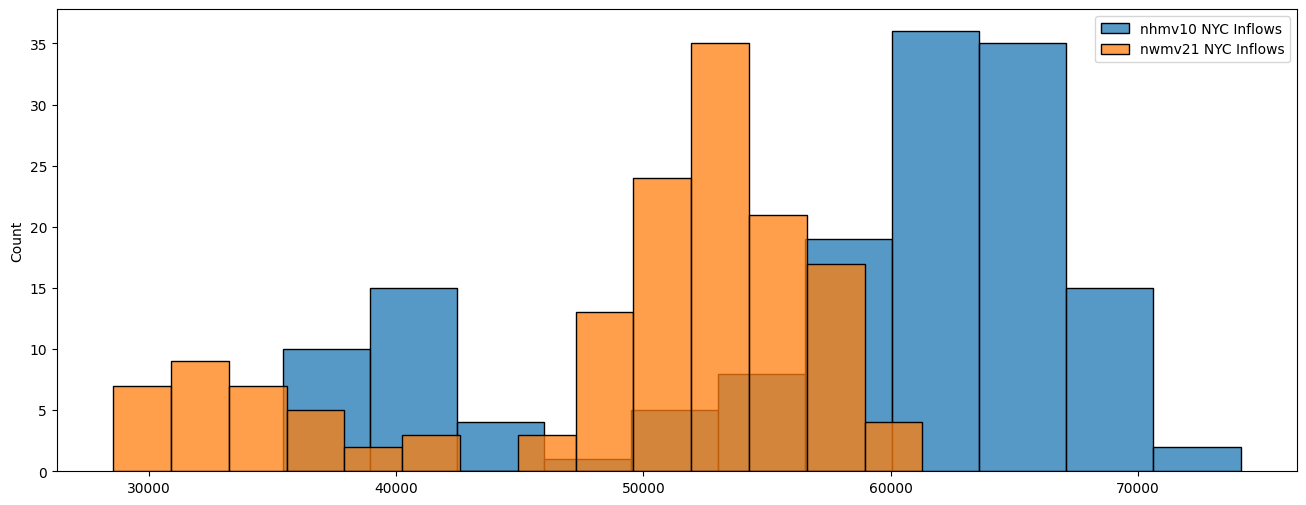

In [16]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))

for model in ['nhmv10', 'nwmv21']:
    ensemble_nyc_inflows = get_ensemble_total_mass_flow(reservoir_inflows[f'pywr_obs_pub_{model}_ObsScaled_ensemble'], 
                                                        reservoir_list,
                                                        start_date, end_date)

    sns.histplot(ensemble_nyc_inflows.sum(axis=1), ax=ax, 
                 label=f'{model} NYC Inflows')
plt.legend()


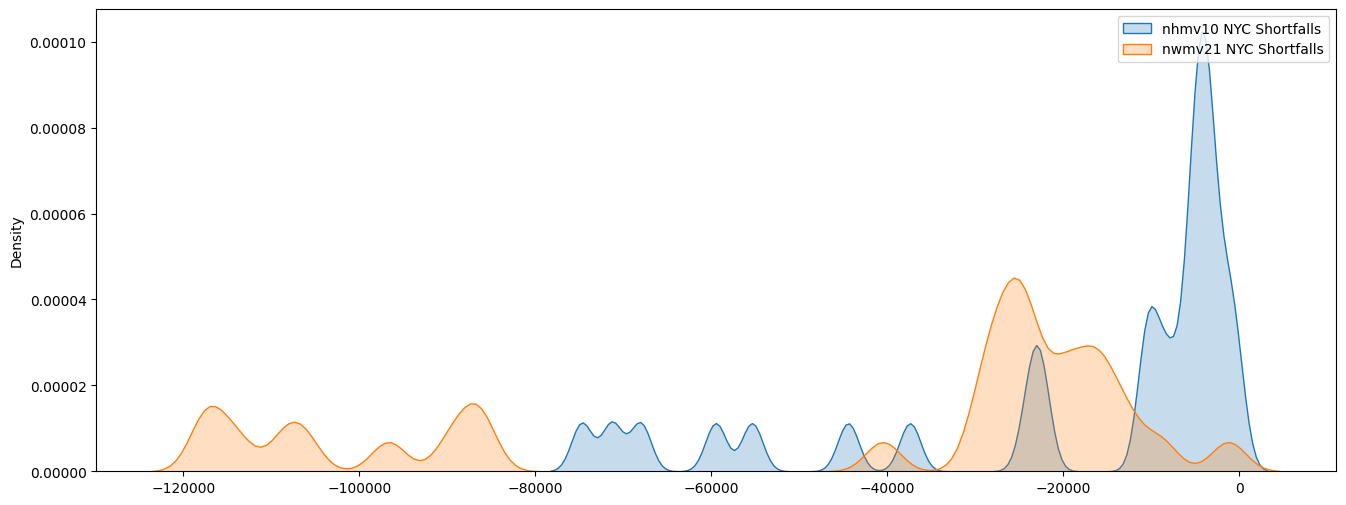

In [17]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))


for model in ['nhmv10', 'nwmv21']:
    ensemble_shortfalls = {}
    for real in major_flows[f'pywr_obs_pub_{model}_ObsScaled_ensemble'].keys():
        Q_mod = major_flows[f'pywr_obs_pub_{model}_ObsScaled_ensemble'][real].loc[start_date:end_date, 'delTrenton']

        Q_mod = Q_mod - delTrenton_target
        Q_mod[Q_mod > 0] = pd.NA
        
        ensemble_shortfalls[real] = Q_mod.values

    ensemble_shortfalls= pd.DataFrame(ensemble_shortfalls)
    ensemble_shortfalls = ensemble_shortfalls.transpose()
        

    sns.kdeplot(ensemble_shortfalls.sum(axis=1), ax=ax, 
                bw_method=0.05,   
                label=f'{model} NYC Shortfalls', fill=True)
plt.legend()


In [23]:
def make_polar_plot(error_metrics, models, node,
                    metric_names, ideal_score, filename, sub_title,
                    metric_mins,
                    colordict = base_model_colors,
                    r_max = 1.5,
                    inner_r = 0.5,
                    normalize = False,
                    use_cmap = True,
                    cmap = 'rainbow',
                    color_by = 0,
                    scale_ideal = False,
                    plot_spokes = True,
                    buffer = 0.0,
                    cut_negatives = True,
                    show_legend = True,
                    figsize = (6,6),
                    save_fig=False,
                    line_width = 1,
                    line_alpha = 0.1):

    # Checks
    #assert(len(ideal_score) == len(metric_names)), 'Length of ideal scores != number of metric names.'
    
    _, n_metrics = error_metrics[models[0]].shape
    n_spokes = n_metrics if use_cmap else n_metrics + 1
    if use_cmap:
        theta =  np.linspace(0, 2*np.pi, n_spokes)
    else:
        theta =  np.linspace(0, 2*np.pi, n_spokes)
        
    def get_radial_data(data, refit_scaler = True, scale_model = None,
                        use_cmap = use_cmap):
        data = data.copy()
        assert(data.shape[1] == len(metric_names)), 'Number of data columns != number of metric names.'

        # Find the minimum and maximum achieved objective values
        data_mins = data.min(axis = 0)
        data_maxs = data.max(axis = 0)

        # Create a normalized data set
        if refit_scaler:
            scaler = MinMaxScaler()
            scale_model = scaler.fit(np.vstack((data, metric_mins)))
            
        norm_data = scale_model.transform(data)
        norm_ideal = scale_model.transform(ideal_score.reshape(1, -1))
        norm_ideal = norm_ideal.flatten()

        # Remove color_by and add the 1st metric to end
        if use_cmap:
            stacked_norm_data = np.hstack((np.delete(norm_data, color_by, axis = 1), np.delete(norm_data, color_by, axis = 1)[:,0:1]))
            stacked_data = np.hstack((np.delete(data, color_by, axis = 1), np.delete(data, color_by, axis = 1)[:,0:1]))
            ideal = np.hstack((np.delete(norm_ideal, color_by, axis = 1), np.delete(norm_ideal, color_by, axis = 1)[:,0:1]))
            ideal = ideal[0,:].flatten()
        else:
            stacked_norm_data = np.hstack((norm_data, norm_data[:,0:1]))
            stacked_data = np.hstack((data, data[:,0:1]))
            ideal = np.hstack((norm_ideal, norm_ideal[0:1]))


        # Define the radial data - scaled according to norms
        r_data = np.zeros_like(stacked_norm_data)

        if scale_ideal:
            shift_ideal = np.ones(n_spokes) / ideal

            if use_cmap:
                shift_ideal = np.hstack((np.delete(shift_ideal, color_by), np.delete(shift_ideal, color_by)[0]))
            else:
                shift_ideal = np.hstack((shift_ideal, shift_ideal[0]))
            r_max = r_max + inner_r + buffer # + max(shift_ideal)
            for i in range(n_spokes):
                if shift_ideal[i] > 0:
                    r_data[:,i] = (stacked_norm_data[:,i]) * shift_ideal[i] + inner_r + buffer
                    ideal[i] = (ideal[i]) * shift_ideal[i] + inner_r + buffer
                else:
                    r_data[:,i] = (stacked_norm_data[:,i]) + 1 + inner_r+ buffer
                    ideal[i] = (ideal[i]) + 1 + inner_r+ buffer

        else:
            r_data = stacked_norm_data + inner_r + buffer
            ideal = ideal + inner_r + buffer
            r_max = r_max + inner_r + buffer

        if cut_negatives:
            r_data[np.argwhere(r_data<0)] = 0
        return theta, r_data, norm_data, ideal, scale_model

    # Initialize plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    cmap = plt.cm.get_cmap(cmap)

    # Plot inner and outer ring
    ax.plot(theta, np.array([r_max]*n_spokes), color = 'grey', alpha = 0.01)
    ax.plot(theta, np.array([inner_r]*n_spokes), color = 'grey', alpha = 0.3)

    # Plot spokes
    if plot_spokes:
        for s in range(n_spokes):
            ax.plot(np.array([theta[s], theta[s]]), np.array([inner_r, max(r_data[:,s])]), color = 'grey', alpha = 0.3)
            # ax.plot(np.array([theta[s], theta[s]]), np.array([max(r_data[:,s]), r_max]), color = 'grey', alpha = 0.3, linestyle = 'dashed')


    # Plot all observations
    for i,m in enumerate(models):
        n_obs, n_metrics = error_metrics[m].shape
        c = colordict[m]
        # Get radial plot data
        if i == 0:
            theta, radial_data, norm_data, ideal, data_scaler = get_radial_data(error_metrics[m], refit_scaler = True, scale_model = None, 
                                                       use_cmap = use_cmap) 
        else:
            _, radial_data, norm_data, _, _ = get_radial_data(error_metrics[m], refit_scaler = False, scale_model = data_scaler, 
                                                        use_cmap = use_cmap)
        
        for j in range(n_obs):
            line_alpha = 1 if n_obs == 1 else line_alpha
                
            if use_cmap:
                ci = cmap(norm_data[j, color_by])
                ax.plot(theta, radial_data[j, :], c = ci, linewidth = line_width, alpha = line_alpha)
            else:
                ax.plot(theta, radial_data[j, :], color=c, linewidth = line_width, alpha = line_alpha)

    # Plot ideal
    ax.plot(theta, ideal, c = 'k', linewidth = 2, linestyle = 'dashed', label = 'Ideal')

    # Add colorbar
    if use_cmap:
        cb = plt.cm.ScalarMappable(cmap = cmap)
        cb.set_array([data_mins[color_by], data_maxs[color_by]])
        cbar = fig.colorbar(cb, anchor = (2.5, 0), pad = 0.05)
        cbar.ax.set_ylabel(metric_names[color_by], fontsize = 16)

        # Add legend
        if show_legend == True:
            ax.legend(bbox_to_anchor = (1.2, 1))

    ## Make radial labels
    # Add lower bound values
    actual_minimums = np.min(r_data, axis = 0)
    if use_cmap:
        spoke_min_labels = np.delete(metric_mins, color_by)
        outter_radial_labels = np.delete(metric_names, color_by)
    else:
        spoke_min_labels = metric_mins
        outter_radial_labels = metric_names
    for s in range(n_spokes - 1):
        # Add text at inner ring
        ax.text(theta[s], inner_r - 0.3*inner_r, f'{spoke_min_labels[s]:.1f}', horizontalalignment = 'center',
                verticalalignment='center', color = 'k', fontsize = 10)
        
        # # Add text at outer ring
        ax.text(theta[s], ideal[s] + 0.2, f'{ideal_score[s]:.1f}', horizontalalignment = 'center',
                verticalalignment='center', color = 'k', fontsize = 10)

    # Graphic features
    ax.set_rmax(r_max)
    ax.set_rticks([])  # Less radial ticks
    ax.spines['polar'].set_visible(False)
    ax.set_rlabel_position(-50.5)  # Move radial labels away from plotted line
    ax.set_title(f'Ensemble Performance Metrics\n{sub_title}', va='bottom', fontsize = 15)
    ax.set_xticklabels(outter_radial_labels, fontsize = 16)
    ax.set_xticks(theta)
    ax.grid(False)
    fig.set_size_inches(figsize)
    fig.set_dpi(200)
    if save_fig:
        plt.savefig(f'./figures/{filename}', bbox_inches = 'tight')
    plt.show()
    return 


In [24]:
def multimodel_polar_plot(results, models, node,
                    metric_names, ideal_score, filename, sub_title,
                    metric_mins,
                    colordict = base_model_colors,
                    r_max = 1.5,
                    inner_r = 0.5,
                    scale_ideal = False,
                    plot_spokes = True,
                    buffer = 0.0,
                    cut_negatives = True,
                    show_legend = True,
                    figsize = (6,6),
                    save_fig=False,
                    line_width = 1,
                    line_alpha = 0.1):

    # Checks
    #assert(len(ideal_score) == len(metric_names)), 'Length of ideal scores != number of metric names.'
    
    n_metrics = len(metric_names) 
    n_spokes = n_metrics + 1
    theta =  np.linspace(0, 2*np.pi, n_spokes)
        
    def get_radial_data(data, refit_scaler = True, scale_model = None,
                        rescale_ideal = False,
                        r_max = r_max, inner_r = inner_r, buffer = buffer):
        data = data.copy()
        assert(data.shape[1] == len(metric_names)), 'Number of data columns != number of metric names.'

        # Create a normalized data set
        if refit_scaler:
            scaler = MinMaxScaler()
            scale_model = scaler.fit(np.vstack((data, metric_mins)))
            
        norm_data = scale_model.transform(data)
        norm_ideal = scale_model.transform(ideal_score.reshape(1, -1))
        norm_ideal = norm_ideal.flatten()

        # add the 1st metric to end
        stacked_norm_data = np.hstack((norm_data, norm_data[:,0:1]))
        stacked_data = np.hstack((data, data[:,0:1]))
        ideal = np.hstack((norm_ideal, norm_ideal[0:1]))


        # Define the radial data - scaled according to norms
        r_data = np.zeros_like(stacked_norm_data)

        if rescale_ideal:
            shift_ideal = np.ones(n_spokes) / ideal
            shift_ideal = np.hstack((shift_ideal, shift_ideal[0]))
            r_max = r_max + inner_r + buffer # + max(shift_ideal)
            for i in range(n_spokes):
                if shift_ideal[i] > 0:
                    r_data[:,i] = (stacked_norm_data[:,i]) * shift_ideal[i] + inner_r + buffer
                    ideal[i] = (ideal[i]) * shift_ideal[i] + inner_r + buffer
                else:
                    r_data[:,i] = (stacked_norm_data[:,i]) + 1 + inner_r+ buffer
                    ideal[i] = (ideal[i]) + 1 + inner_r+ buffer

        else:
            r_data = stacked_norm_data + inner_r + buffer
            ideal = ideal + inner_r + buffer
            r_max = r_max + inner_r + buffer

        if cut_negatives:
            r_data[r_data<0] = 0
        return theta, r_data, norm_data, ideal, r_max, scale_model

    # Initialize plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Plot inner and outer ring
    ax.plot(theta, np.array([r_max]*n_spokes), color = 'grey', alpha = 0.01)
    ax.plot(theta, np.array([inner_r]*n_spokes), color = 'grey', alpha = 0.3)

    # Plot spokes
    if plot_spokes:
        for s in range(n_spokes):
            ax.plot(np.array([theta[s], theta[s]]), np.array([inner_r, r_max]), color = 'grey', alpha = 0.3)
            # ax.plot(np.array([theta[s], theta[s]]), np.array([max(r_data[:,s]), r_max]), color = 'grey', alpha = 0.3, linestyle = 'dashed')


    # Plot all observations
    for i,m in enumerate(models):
        
        # Get error metrics
        error_metrics = get_ensemble_error_metrics(results[m], observed_results=results['obs'], model = m, node=node)
        
        n_obs, n_metrics = error_metrics.shape
        c = colordict[m]
        # Get radial plot data
        if i == 0:
            theta, radial_data, norm_data, ideal, r_max, data_scaler = get_radial_data(error_metrics[metric_names].values, 
                                                                                       rescale_ideal=True,
                                                                                refit_scaler = True, scale_model = None) 
        else:
            _, radial_data, norm_data, _, _, _ = get_radial_data(error_metrics[metric_names].values, 
                                                                 rescale_ideal=True,
                                                              refit_scaler = False, scale_model = data_scaler)
        
        for j in range(n_obs):
            line_alpha = 1 if n_obs == 1 else line_alpha
                
            ax.plot(theta, radial_data[j, :], color=c, linewidth = line_width, alpha = line_alpha)

    # Plot ideal
    ax.plot(theta, ideal, c = 'k', linewidth = 2, linestyle = 'dashed', label = 'Ideal')

    # Add legend
    if show_legend == True:
        ax.legend(bbox_to_anchor = (1.2, 1))

    ## Make radial labels
    # Add lower bound values
    actual_minimums = np.min(radial_data, axis = 0)
    spoke_min_labels = metric_mins
    outter_radial_labels = metric_names
    for s in range(n_spokes - 1):
        # Add text at inner ring
        ax.text(theta[s], inner_r - 0.3*inner_r, f'{spoke_min_labels[s]:.1f}', horizontalalignment = 'center',
                verticalalignment='center', color = 'k', fontsize = 10)
        
        # # Add text at outer ring
        ax.text(theta[s], ideal[s] + 0.2, f'{ideal_score[s]:.1f}', horizontalalignment = 'center',
                verticalalignment='center', color = 'k', fontsize = 10)

    # Graphic features
    ax.set_rmax(r_max)
    ax.set_rticks([])  # Less radial ticks
    ax.spines['polar'].set_visible(False)
    ax.set_rlabel_position(-70.5)  # Move radial labels away from plotted line
    ax.set_title(f'Ensemble Performance Metrics\n{sub_title}', va='bottom', fontsize = 15)
    ax.set_xticklabels(outter_radial_labels, fontsize = 14)
    ax.set_xticks(theta)
    ax.grid(False)
    fig.set_size_inches(figsize)
    fig.set_dpi(200)
    if save_fig:
        plt.savefig(f'./figures/{filename}', bbox_inches = 'tight')
    plt.show()
    return 


ValueError: simulation and evaluation arrays feature incompatible dimensions

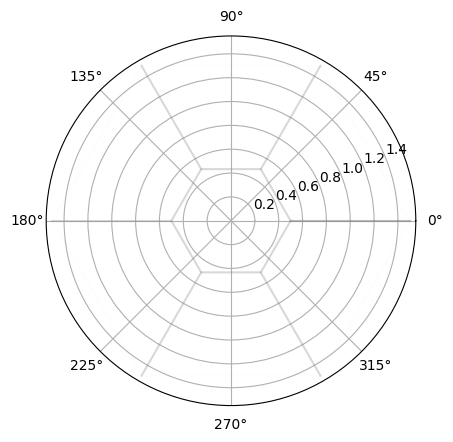

In [25]:
use_metrics = ['nse', 'kge', 'r', 'lognse', 'logkge', 'logr']
plot_models = ['pywr_obs_pub_nhmv10_ObsScaled_ensemble']

for plot_node in ['outletAssunpink']:

    multimodel_polar_plot(major_flows, models=plot_models, node=plot_node, 
                    metric_names=use_metrics, ideal_score=np.array([1,1,1,1,1,1]),
                    colordict=base_model_colors,
                    filename=f'polar_errors_{plot_node}_{plot_models}.png', sub_title=f'Simulated Flows at {plot_node}', metric_mins = [-1,-1,0,-1,-1,0], r_max = 1.5,
                    line_alpha=0.5,
                    figsize=(7,7),
                    scale_ideal=True,
                    plot_spokes=True,
                    save_fig=True)

In [453]:
base_model_colors['pywr_obs_pub_nhmv10_ObsScaled_ensemble'] = 'cornflowerblue'